# Random Background Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/random_background_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin

env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin


## Functions

In [2]:
# split data into GC content matched training and test data
def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [3]:
# split data into GC content matched training and test data
def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [51]:
def signmoid(x):
    result = 1/(1 + np.exp(-x))
    return result

## Copy Score Files

In [250]:
%%bash
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_score_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_sequence_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_strand_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_start_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/motif_end_frame_C57BL6J.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/summary_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/annotation_frame.pickle ./
cp /gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/peak_sequences/C57BL6J.fa ./

## Read in Score Files

In [4]:
motif_score_frame=pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values

scaler = preprocessing.StandardScaler()
standardized_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
standardized_motif_frame.columns = motif_score_frame.columns.values[3:]
standardized_motif_frame.index = motif_score_frame.index.values

_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')

### read in sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  

## Create background peaks from genomic sequences from each chromosome

In [6]:
# def getRandomBackgroundSwitch(target_positions, 
#                         size_ratio = 1.0, 
#                         tolerance = 0.05, 
#                         N_threshold = 0.5 ):
#     '''
#     target_sequences: 2D numpy array, list of genomic coordinates for target sequences [[chr,start,end],...]
#     size_ratio: float, number of background sequences relative to target sequences
#     tolerance: float, max difference in GC content between True and background labelled samples
#     *** Uses mm10 genome taken from Homer ***
#     '''
    
#     ###load mm10 genome into memory
    
#     # index target positions
#     # {chr:[]}, value is chromosome length boolean array
#     # largest chromosome has 200 million bps 
#     _chromosomes = ['chr1' , 'chr2' , 'chr3' , 'chr4' , 'chr5' , 
#                     'chr6' , 'chr7' , 'chr8' , 'chr9' , 'chr10', 
#                     'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 
#                     'chr16', 'chr17', 'chr18', 'chr19', 'chrX']
#     _chrom_size_dict = {}
#     _chrom_seq_dict = {}
#     for chrom in _chromosomes:
#         with open('./mm10_genome/' + chrom + '.fa') as f:
#             data = f.readlines()
#         seq = ''.join(x.upper().strip() for x in data[1:])
#         size = len(seq)
#         _chrom_size_dict[chrom] = size
#         _chrom_seq_dict[chrom] = seq
#     _numChromosomes = len(_chromosomes)
    
#     target_chr_position_dict = {x:np.zeros(200000000) for x in _chromosomes} 
#     ### initialize target_chr_position_dict using target positions
#     ### retreive target sequences
#     target_sequences = []
#     for pos in target_positions:
#         chrom = pos[0]        
#         start = pos[1]
#         end = pos[2]
#         target_chr_position_dict[chrom][start-1:end] = 1 # use 0 indexing of position, versus 1 indexing used in fasta
#         seq = _chrom_seq_dict[chrom][start:(end+1)]
#         target_sequences.append(seq)
#     ### calculate GC content and average length of the target sequences
#     target_gc_count = 0
#     target_length_count = 0
#     for s in target_sequences:
#         target_gc_count += s.count('G')
#         target_gc_count += s.count('C')
#         target_length_count += len(s)
#     target_gc_content = target_gc_count/(target_length_count+0.0000001) # GC content of target sequences
#     mean_target_length = target_length_count/len(target_sequences) # average length of target sequences
#     mean_target_length = int(mean_target_length)
    
#     ### select random genomic loci such that they do no overlap target sequences
#     numSelected = 0
#     numToSelect = len(target_positions) * size_ratio * 2 # candidate pool of background seqs is 2X larger
#     candidate_positions = []
#     while numSelected < numToSelect:
#         # select random chromsome
#         chromIndex = np.random.randint(_numChromosomes)
#         randChrom = _chromosomes[chromIndex]
#         randChromSize = _chrom_size_dict[randChrom]
#         # must find non overlapping segment on this chromosome before moving on
#         selectedSequence = False
#         while not selectedSequence:
#             randStart = np.random.randint(randChromSize)
#             randEnd = randStart + mean_target_length
#             overlap_sum = np.sum(target_chr_position_dict[randChrom][randStart:(randEnd + 1)])
#             if not overlap_sum > 0:
#                 selectedSequence = True
#                 numSelected+=1
#                 candidate_positions.append([randChrom, randStart, randEnd])

#     ### retrieve sequences of random genomic loci
#     numFiltered=0
#     filtered_candidate_positions = []
#     numNallowed = int(N_threshold * mean_target_length)
#     for cp in candidate_positions:
#         chrom = cp[0]
#         start = cp[1]
#         end = cp[2]
#         candidate_seq = _chrom_seq_dict[chrom][start:(end+1)]
#         numN = candidate_seq.count('N')
#         # throw away background peaks containing greater than this fraction of N
#         if numN <= numNallowed:
#             filtered_candidate_positions.append((chrom, start, end,candidate_seq))

#     if len(filtered_candidate_positions) < len(target_positions):
#         print('The genome is vast and empty and filled with Ns')
#         return None
       
#     ### select random set of candidate background loci
#     random.shuffle(filtered_candidate_positions)
    
#     toReturn_positions = filtered_candidate_positions[:len(target_positions)]
#     remaining_positions = filtered_candidate_positions[len(target_positions):]
#     # calcuate GC content of background samples
#     background_gc_count = 0
#     background_length = 0
#     for trp in toReturn_positions:
#         s = trp[3]
#         background_gc_count += s.count('G')
#         background_gc_count += s.count('C')
#         background_length += len(s)
#     background_gc_content = background_gc_count/(background_length+0.0000001)
        
#     numToReturn = len(toReturn_positions)
#     numRemaining = len(remaining_positions)
#     counter = 0
#     while abs(target_gc_content - background_gc_content) > tolerance:
#         # swith background GC sequences until GC content matches tolerance
#         switched_seq = False       
#         while not switched_seq:
#             # sequence to be switched out
#             rand_index = np.random.randint(numToReturn)
#             current_seq = toReturn_positions[rand_index][3]
#             current_gc_count = current_seq.count('G')+ current_seq.count('C')
#             current_length = len(current_seq)
#             current_gc = current_gc_count/current_length
            
#             # sequence to be switched out
#             switch_index = np.random.randint(numRemaining)
#             switch_seq = remaining_positions[switch_index][3]
#             switch_gc_count = switch_seq.count('G')+ switch_seq.count('C')
#             switch_length = len(switch_seq)
#             switch_gc = switch_gc_count/switch_length
#             if target_gc_content > background_gc_content:
#                 # switch sequences that would increase overall GC content of background sequences
#                 if switch_gc > current_gc:
#                     switched_seq = True
#             else:
#                 # switch sequences that would decrease overall GC content of background sequences
#                 if switch_gc < current_gc:
#                     switched_seq = True
#         counter +=1
#         if counter % 1000 == 0:
#             print(background_gc_content, target_gc_content, tolerance)
#         # switch sequences
#         temp_pos = toReturn_positions[rand_index]
#         toReturn_positions[rand_index] = remaining_positions[switch_index]
#         remaining_positions[switch_index] = temp_pos

#         # update background GC content
#         background_gc_count -= current_gc_count
#         background_length -= current_length
#         background_gc_count += switch_gc_count
#         background_length += switch_length
        
#         background_gc_content = background_gc_count/background_length
          
        
#     print(target_gc_content, background_gc_content)
#     return None
    

In [5]:
def getRandomBackground(target_positions, 
                        size_ratio = 1.0, 
                        tolerance = 0.01, 
                        N_threshold = 0.5 ):
    '''
    target_sequences: 2D numpy array, list of genomic coordinates for target sequences [[chr,start,end],...]
    size_ratio: float, number of background sequences relative to target sequences
    tolerance: float, max difference in GC content between True and background labelled samples
    *** Uses mm10 genome taken from Homer ***
    '''
    
    ###load mm10 genome into memory
    
    # index target positions
    # {chr:[]}, value is chromosome length boolean array
    # largest chromosome has 200 million bps 
    _chromosomes = ['chr1' , 'chr2' , 'chr3' , 'chr4' , 'chr5' , 
                    'chr6' , 'chr7' , 'chr8' , 'chr9' , 'chr10', 
                    'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 
                    'chr16', 'chr17', 'chr18', 'chr19', 'chrX']
    _chrom_size_dict = {}
    _chrom_seq_dict = {}
    for chrom in _chromosomes:
        with open('./mm10_genome/' + chrom + '.fa') as f:
            data = f.readlines()
        seq = ''.join(x.upper().strip() for x in data[1:])
        size = len(seq)
        _chrom_size_dict[chrom] = size
        _chrom_seq_dict[chrom] = seq
    _numChromosomes = len(_chromosomes)
    
    target_chr_position_dict = {x:np.zeros(200000000) for x in _chromosomes} 
    ### initialize target_chr_position_dict using target positions
    ### retreive target sequences
    target_sequences = []
    for pos in target_positions:
        chrom = pos[0]        
        start = pos[1]
        end = pos[2]
        target_chr_position_dict[chrom][start-1:end] = 1 # use 0 indexing of position, versus 1 indexing used in fasta
        seq = _chrom_seq_dict[chrom][start:(end+1)]
        target_sequences.append(seq)
    ### calculate GC content and average length of the target sequences
    target_gc_count = 0
    target_length_count = 0
    for s in target_sequences:
        target_gc_count += s.count('G')
        target_gc_count += s.count('C')
        target_length_count += len(s)
    target_gc_content = target_gc_count/(target_length_count+0.0000001) # GC content of target sequences
    mean_target_length = target_length_count/len(target_sequences) # average length of target sequences
    mean_target_length = int(mean_target_length)
    
    ### select random genomic loci such that they do no overlap target sequences
    numSelected = 0
    numToSelect = len(target_positions) * size_ratio * 2 # candidate pool of background seqs is 2X larger
    candidate_positions = []
    numNallowed = int(N_threshold * mean_target_length) # number of allowable Ns
    counter = 0
    while numSelected < numToSelect:
        if counter % 100000 == 0:
            print(counter, numSelected)
        # select random chromsome
        chromIndex = np.random.randint(_numChromosomes)
        randChrom = _chromosomes[chromIndex]
        randChromSize = _chrom_size_dict[randChrom]
        # must find non overlapping segment on this chromosome before moving on
        selectedSequence = False
        while not selectedSequence:
            counter += 1
            randStart = np.random.randint(randChromSize)
            randEnd = randStart + mean_target_length
            overlap_sum = np.sum(target_chr_position_dict[randChrom][randStart:(randEnd + 1)])
            
            if not overlap_sum > 0:
                randSeq = _chrom_seq_dict[randChrom][randStart:(randEnd+1)]
                numN = randSeq.count('N')
                if numN <= numNallowed:
                    rand_gc_count = randSeq.count('G')+ randSeq.count('C')
                    rand_gc = rand_gc_count/mean_target_length
                    if abs(target_gc_content - rand_gc) <= tolerance:
                        selectedSequence = True
                        numSelected+=1
                        candidate_positions.append([randChrom, randStart, randEnd, randSeq])
    # calcuate GC content of background samples
    background_gc_count = 0
    background_length = 0
    for cp in candidate_positions:
        s = cp[3]
        background_gc_count += s.count('G')
        background_gc_count += s.count('C')
        background_length += len(s)
    background_gc_content = background_gc_count/(background_length+0.0000001)
    print(target_gc_content,background_gc_content)
    return candidate_positions

In [234]:
# generate random genomic background for all monomers
strain = 'c57bl6'
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_positions = summary_frame[summary_frame.index.isin(target_indices)][['chr', 'start', 'end']].values
        start = time.time()
        backgroundPositions = getRandomBackground(target_positions, N_threshold =1.0, tolerance=0.05, size_ratio=5)
        end = time.time()
        print(monomer, treatment, end - start)
        pickle.dump(backgroundPositions,open('./background_pickles/' + monomer + '_' + treatment + '_background.pickle', 'wb'))

### Background positions to create peak files


In [26]:
strain = 'c57bl6'
! if [ ! -d ./background_peak_files ]; then mkdir ./background_peak_files; fi
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        backgroundPositions = pickle.load(open('./background_pickles/' + monomer + '_' + treatment + '_background.pickle', 'rb'))
        outFile = open('./background_peak_files/' + strain + '_' + monomer + '_' + treatment + '-background_peaks.tsv' , 'w')
        outFile.write('\t'.join(['#PeakID','chr','start','end','strand','idrScore', 'count','\n']))
        counter = 0
        for pos in backgroundPositions:
            chrom = pos[0]
            start = str(pos[1])
            end = str(pos[2])
            strand = '+' # arbitrary - for compatibility with downstream scripts
            score = '1' # arbitrary - for compatibility with downstream scripts
            randID = 'background_' + str(np.random.randint(10000)) + '_' + str(counter)
            counter += 1
            outFile.write('\t'.join([randID, chrom, start, end, strand, score, score, '\n']))
        outFile.close()
        
    

### Merge Peak Files

In [27]:
%%capture
! mergePeaks -d given ./background_peak_files/*tsv > ./background_merged_peaks.tsv


In [28]:
! makeSummaryFile.py ./background_merged_peaks.tsv ./background_group_summary.tsv ./background_peak_files/*

sys:1: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
Finished reading merged peak file...
Integrating scores for c57bl6_atf3_kla-background
Integrating scores for c57bl6_atf3_veh-background
Integrating scores for c57bl6_cjun_kla-background
Integrating scores for c57bl6_cjun_veh-background
Integrating scores for c57bl6_fos_kla-background
Integrating scores for c57bl6_fos_veh-background
Integrating scores for c57bl6_junb_kla-background
Integrating scores for c57bl6_junb_veh-background
Integrating scores for c57bl6_jund_kla-background
Integrating scores for c57bl6_jund_veh-background


In [8]:
# read in peak data data
summary_background_frame = pd.read_csv('./background_group_summary.tsv' , sep='\t')
summary_background_frame = summary_background_frame.fillna('0')
for col in summary_background_frame.columns[5:]:
    floatValues = []
    for val in summary_background_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_background_frame[col] = floatValues
summary_background_frame.index = summary_background_frame['ID'].values

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### create a script to scan for motifs using FIMO



In [29]:
%%bash
if [ ! -d ./peak_sequences ] ;
    then mkdir ./peak_sequences
else
    rm ./peak_sequences/*
fi

In [37]:
%%bash
perl /home/vlink/mouse_strains/marge/analysis/extract_seq_from_peakfiles.pl -strains C57BL6J -file ./background_merged_peaks.tsv -output ./peak_sequences/C57BL6J_marge.fa





Saving peaks
Loading shift vectors


In [39]:
# reformat fastq files to use homer peak IDs

coordinate_peakID_dict = {} # {chr_start_end:homerID}
with open ('./background_merged_peaks.tsv') as f:
    data = f.readlines()
for line in data[1:]:
    tokens = line.split('\t')
    coordinate = '_'.join(tokens[1:4])
    peakID = tokens[0].strip()
    coordinate_peakID_dict[coordinate] = tokens[0]



In [40]:
for fastaFile in os.listdir('./peak_sequences/'):
    if 'marge' in fastaFile:
        strain = fastaFile.split('_')[0]
        outFile = open('./peak_sequences/' + fastaFile.replace('_marge',''), 'w')
        print(fastaFile)
        with open('./peak_sequences/' + fastaFile) as f:
            data = f.readlines()
        for line in data:
            if '>' in line:
                coordinate = line[1:].replace('_'+strain,'').strip()
                
                peakID = coordinate_peakID_dict[coordinate]
                outFile.write('>' + peakID + '\n')
               
            else:
                outFile.write(line)
        outFile.close()

C57BL6J_marge.fa


In [252]:
!cp ./peak_sequences/C57BL6J.fa ./C57BL6J_background.fa

In [63]:
# create a script to scan for motifs using FIMO
! if [ ! -d /home/jtao/analysis/random_background_analysis/fimo_results/ ]; then mkdir /home/jtao/analysis/random_background_analysis/fimo_results/; fi
! if [ ! -d /home/jtao/analysis/random_background_analysis/fimo_out/ ]; then mkdir /home/jtao/analysis/random_background_analysis/fimo_out/; fi
! rm -rf ./fimo_out/*
! rm -rf ./fimo_result/*


pthresh = 0.01
motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs/'

fimo_results_dir = './fimo_results'

for fastaFile in os.listdir('./peak_sequences/'):
    if not 'marge' in fastaFile:
        print(fastaFile)
        strain = fastaFile.split('.')[0]
        count = 0
        scriptFile = open('scanMotifs_background_'+ strain +'.sh','w')
        for m in os.listdir(motif_dir):
            if 'fimo' in m:
                fimo_out_dir = './fimo_out/' + strain + '_' +m.replace('.fimo','')
                outPath = fimo_results_dir + '/' +strain + '_' + m.replace('.fimo','') +'.txt'
                scriptFile.write(
                    '(sleep ' + str(15 * count) + 
                    's; fimo --text --max-stored-scores 2000000 --output-pthresh ' + 
                    str(pthresh) +' --oc ' + fimo_out_dir + ' ' +
                    motif_dir + '/' + m + ' ./peak_sequences/' + fastaFile +
                    '> ' + outPath + ' ) & \n')
                count+=1
        scriptFile.close()




C57BL6J.fa


In [ ]:
%%bash
chmod a+x ./scanMotifs*.sh
for i in ./scanMotifs*sh; 
    do echo 'sleeping...';
    echo $i;
    $i;
#     sleep 5m;
done



### Read in Motif Scores

In [70]:
from numba import jit

In [208]:
# @jit(nopython=False)
# def readMotifScores(fimoPaths, all_peak_ids):
#     '''
#     merges FIMO outputs for many motifs into a single data object
#     inputs: list of file paths to FIMO results
#     '''
    
#     ### initialize data structures for storing output
#     for fimo_result_path in fimoPaths:
#         toReturn = []
#         # read in fimo result file
#         motif_name = fimo_result_path.split('/')[-1].replace('.fimo','')
#         fimo_result_file = open(fimo_result_path, 'r')
#         fimo_result_data = fimo_result_file.readlines()
#         fimo_result_file.close()
        
#         # initialize arrays for storing current file
#         ids = []
#         scores = []
#         strands = []
#         sequences = []
#         starts = []
#         ends = []
#         fimo_result_data.pop(0) # skip header
#         for line in fimo_result_data: 
#             # break up row into column values
#             tokens = line.split('\t')
#             motif_name = tokens[0]
#             peak_id = tokens[1]
#             start = tokens[2]
#             stop = tokens[3]
#             strand = tokens[4]
#             score = tokens[5]
#             pvalue = tokens[6]
#             sequence = tokens[7]
            
#             ids.append(peak_id)
#             scores.append(score)
#             strands.append(strand)
#             sequences.append(sequence)
#             starts.append(start)
#             ends.append(end)        

#         id_count_dict = {} #{PeakID:motifCount}
#         id_values_dict = {} # {PeakID:(motifScore, motifSequence, motifStrand, motifStart, motifEnd)}

#         for i in range(len(ids)):
#             currentScore = float(scores[i])
#             currentSequence = sequences[i]
#             currentStrand = strands[i]
#             currentStart = int(starts[i])
#             currentEnd = int(ends[i])

#             if currentScore < 0.0:
#                 currentScore = 0.0


#             values = (currentScore, currentSequence, currentStrand, currentStart, currentEnd)

#             if ids[i] in id_values_dict:
#                 if currentScore > id_values_dict[ids[i]][0]:
#                     id_values_dict[ids[i]] = values
#                     id_count_dict[ids[i]] += 1
#             else:
#                 id_values_dict[ids[i]] = values
#                 id_count_dict[ids[i]] = 1
                
#         # fill in missing values
#         sorted_scores = []
#         sorted_sequences = []
#         sorted_strands = []
#         sorted_starts = []
#         sorted_ends = []
#         sorted_counts = []

#         for peak_id in all_peak_ids:
#             if peak_id in id_values_dict:
#                 current_values = id_values_dict[peak_id]
#                 current_score = current_values[0]
#                 current_sequence = current_values[1]
#                 current_strand = current_values[2]
#                 current_start = current_values[3]
#                 current_end = current_values[4]
#                 if peak_id in id_count_dict:
#                     current_count = id_count_dict[peak_id]
#                 else:
#                     current_count = 0
#             else:
#                 current_score = ''
#                 current_sequence = ''
#                 current_strand = '?'
#                 current_start = -1
#                 current_end = -1
#                 current_count = 0
#             sorted_scores.append(current_score)
#             sorted_sequences = [current_sequence]
#             sorted_strands = [current_strand]
#             sorted_starts = [current_start]
#             sorted_ends = [current_end]
#             sorted_counts = [current_count]
        

#         toReturn.append([sorted_scores,sorted_sequences,sorted_strands,sorted_starts,sorted_ends,sorted_counts])

    
#     return None
    
    
    

In [178]:
testPaths  = fimoPaths[:2]
all_peak_ids = summary_background_frame.index.values
readMotifScores(testPaths, all_peak_ids)

In [ ]:
motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs/'

for fastaFile in os.listdir('./peak_sequences/'):
    if not 'marge' in fastaFile:
        print(fastaFile)
        strain = fastaFile.split('.')[0]

        peak_start_dict = dict(zip(summary_background_frame['ID'].values, summary_background_frame['start'].values))

        motif_score_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_score_background_frame.index=motif_score_background_frame['ID'].values

        motif_sequence_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_sequence_background_frame.index=motif_score_background_frame['ID'].values

        motif_strand_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_strand_background_frame.index=motif_score_background_frame['ID'].values

        motif_start_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_start_background_frame.index=motif_score_background_frame['ID'].values

        motif_end_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_end_background_frame.index=motif_score_background_frame['ID'].values

        motif_count_background_frame = summary_background_frame[['ID', 'Factors', 'chr']]
        motif_count_background_frame.index = motif_count_background_frame['ID'].values

        counter=0
        for m in sorted(os.listdir(motif_dir)):
            counter+=1
            if '.fimo' in m:
                print(counter,m)
                motif_results = './fimo_results/' + strain + '_' + m.replace('.fimo','') +'.txt'
                fimo_result_background_frame=pd.read_csv(motif_results, 
                                              skiprows=1,
                                              names=['motif_name', 
                                                     'peak_id', 
                                                     'start', 
                                                     'stop', 
                                                     'strand', 
                                                     'score', 
                                                     'pvalue', 
                                                     'sequence'],
                                              sep='\t')
                motif_name = m.replace('.fimo','')

                id_count_dict = {} #{PeakID:motifCount}
                id_values_dict = {} # {PeakID:(motifScore, motifSequence, motifStrand, motifStart, motifEnd)}

                ids = fimo_result_background_frame['peak_id'].values
                scores = fimo_result_background_frame['score'].values
                strands = fimo_result_background_frame['strand'].values
                sequences = fimo_result_background_frame['sequence']
                starts = fimo_result_background_frame['start']
                ends = fimo_result_background_frame['stop']

                for i in range(len(ids)):
                    currentScore = float(scores[i])
                    currentSequence = sequences[i]
                    currentStrand = strands[i]
                    currentStart = int(starts[i])
                    currentEnd = int(ends[i])

                    if currentScore < 0.0:
                        currentScore = 0.0
                    
                    
                    values = (currentScore, currentSequence, currentStrand, currentStart, currentEnd)

                    if ids[i] in id_values_dict:
                        if currentScore > id_values_dict[ids[i]][0]:
                            id_values_dict[ids[i]] = values
                            id_count_dict[ids[i]] += 1
                    else:
                        id_values_dict[ids[i]] = values
                        id_count_dict[ids[i]] = 1

                sorted_values = [id_values_dict[x] if x in id_values_dict else (0,'','?',-1,-1,0) for x in  motif_score_background_frame['ID'].values]
                sorted_scores = [x[0] for x in sorted_values]
                sorted_sequences = [x[1] for x in sorted_values]
                sorted_strands = [x[2] for x in sorted_values]
                sorted_starts = [x[3] for x in sorted_values]
                sorted_ends = [x[4] for x in sorted_values]
                sorted_counts = [id_count_dict[x] if x in id_count_dict else 0 for x in motif_score_background_frame['ID'].values]

                motif_score_background_frame[motif_name] = sorted_scores
                motif_sequence_background_frame[motif_name] = sorted_sequences
                motif_strand_background_frame[motif_name] = sorted_strands
                motif_start_background_frame[motif_name] = sorted_starts
                motif_end_background_frame[motif_name] = sorted_ends
                motif_count_background_frame[motif_name] = sorted_counts


        motif_score_background_frame.to_pickle('motif_score_background_frame_'+  strain + '.pickle')
        motif_score_background_frame.to_csv('motif_scores_'+  strain + '.tsv', sep='\t', index=False)

        motif_sequence_background_frame.to_pickle('motif_sequence_background_frame_'+  strain + '.pickle')
        motif_sequence_background_frame.to_csv('motif_sequence_'+  strain + '.tsv', sep='\t', index=False)

        motif_strand_background_frame.to_pickle('motif_strand_background_frame_'+  strain + '.pickle')
        motif_strand_background_frame.to_csv('motif_strand_'+  strain + '.tsv', sep='\t', index=False)

        motif_start_background_frame.to_pickle('motif_start_background_frame_'+  strain + '.pickle')
        motif_start_background_frame.to_csv('motif_start_background_frame_'+  strain + '.tsv', sep='\t', index=False)

        motif_end_background_frame.to_pickle('motif_end_background_frame_'+  strain + '.pickle')
        motif_end_background_frame.to_csv('motif_end_background_frame_'+  strain + '.tsv', sep='\t', index=False)

        motif_count_background_frame.to_pickle('motif_count_background_frame_'+  strain + '.pickle')
        motif_count_background_frame.to_csv('motif_count_background_frame_'+  strain + '.tsv', sep='\t', index=False)



## Run Classifier using Open Chromatin Background

In [14]:
numIterations = 5
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
test_size = 0.5
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  



In [21]:

# for monomers using all motifs
strain = 'c57bl6'
factor_auc_dict = {}
factor_precision_dict = {}
factor_coeff_dict = {}
factor_prob_dict = {}
factor_meanCoeff_dict = {}
factor_intercept_dict = {}
factor_meanIntercept_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_' + treatment for x in factors]].sum(axis=1) > 0].index.values  
        features = standardized_motif_frame[standardized_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)][strain + '_' + monomer + '_' + treatment] > 0.0
        if np.sum(labels) >= 100:
            all_aucs = []
            all_coefficients = []
            all_probs = None
            all_precisions = []
            all_intercepts = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)

                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

                lr_classifier.fit(training_features, training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

                # score all sequences
                probs = lr_classifier.predict_proba(features)[:, 1]

                current_coefficients = lr_classifier.coef_.flatten()
                all_coefficients.append(current_coefficients)
                all_intercepts.append(lr_classifier.intercept_[0])
                
                if all_probs == None:
                    all_probs = probs
                else:
                    all_probs = all_probs + probs
            mean_coefficients = np.mean(all_coefficients, axis=0)
            
            factor_auc_dict[monomer + '_' + treatment]= all_aucs
            factor_precision_dict[monomer + '_' + treatment] = all_precisions
            factor_coeff_dict[monomer + '_' + treatment] = all_coefficients
            factor_prob_dict[monomer + '_' + treatment] = all_probs
            factor_meanCoeff_dict[monomer + '_' + treatment] = mean_coefficients
            factor_intercept_dict[monomer + '_' + treatment] = all_intercepts
            factor_meanIntercept_dict[monomer + '_' + treatment] = np.mean(all_intercepts)
            print(monomer + '_' + treatment,
                  'roc:', np.mean(all_aucs), np.var(all_aucs),
                  'precision:', np.mean(all_precisions), np.var(all_precisions),  
                  'numTestPositives:', np.sum(test_labels)
                 )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


atf3_veh roc: 0.838308151397 3.42668769667e-06 precision: 0.713111619108 2.83975808567e-05 numTestPositives: 10887
cjun_veh roc: 0.811068496666 2.95685003097e-06 precision: 0.465996411622 1.97786659228e-05 numTestPositives: 6400
fos_veh roc: 0.857788300852 8.36960367694e-06 precision: 0.344665776594 0.000103174307415 numTestPositives: 963
junb_veh roc: 0.675966647026 2.17115357292e-05 precision: 0.019644210338 1.5656963107e-06 numTestPositives: 249
jund_veh roc: 0.807082295123 1.29827752997e-06 precision: 0.563010095965 2.76117878846e-05 numTestPositives: 8958
atf3_kla roc: 0.83111123263 1.23124235032e-06 precision: 0.802415238772 1.33146558513e-06 numTestPositives: 17379
cjun_kla roc: 0.806096901394 2.73755429337e-06 precision: 0.479272999676 7.63116096659e-06 numTestPositives: 8088
fos_kla roc: 0.829903385855 3.37051389239e-07 precision: 0.658310152952 8.51387392689e-06 numTestPositives: 10777
junb_kla roc: 0.828184696644 4.59297821879e-06 precision: 0.477040581226 1.80293138999e-05 

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


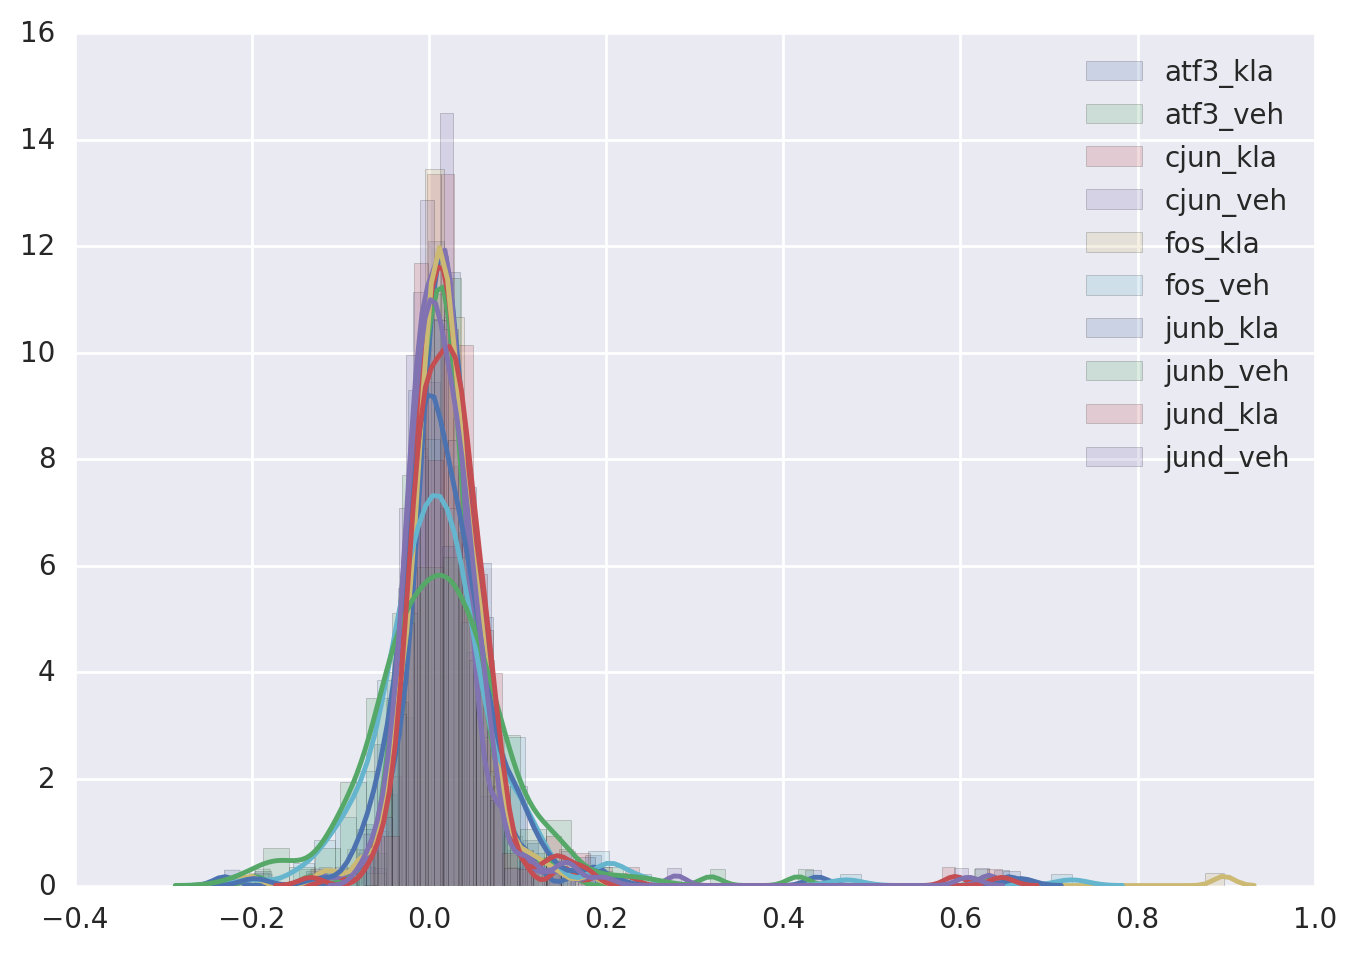

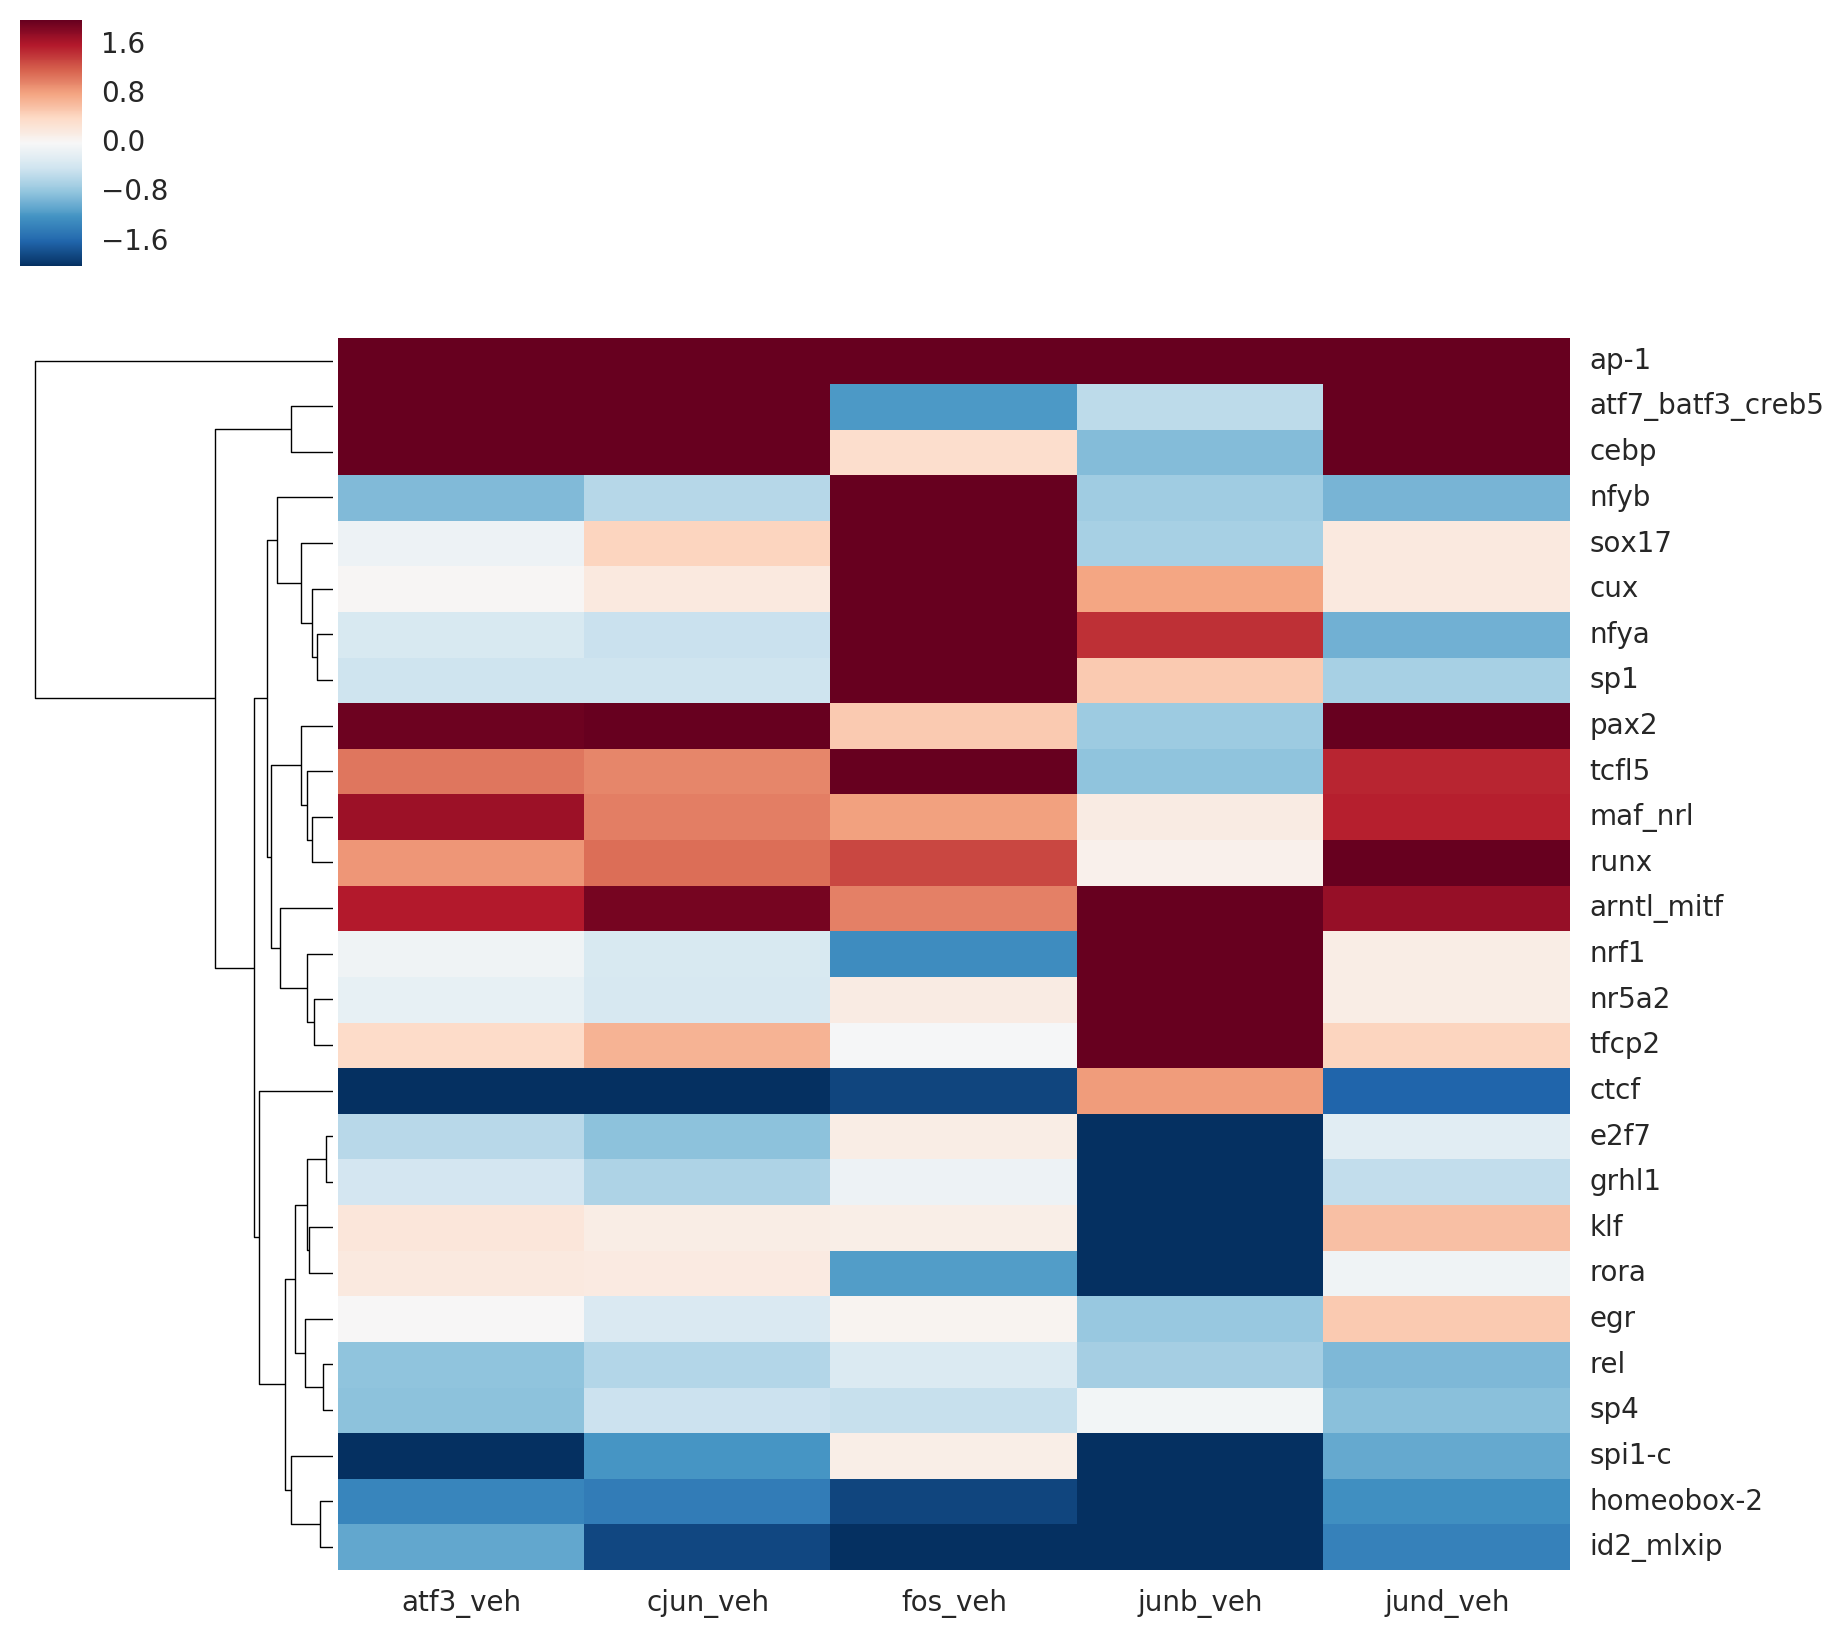

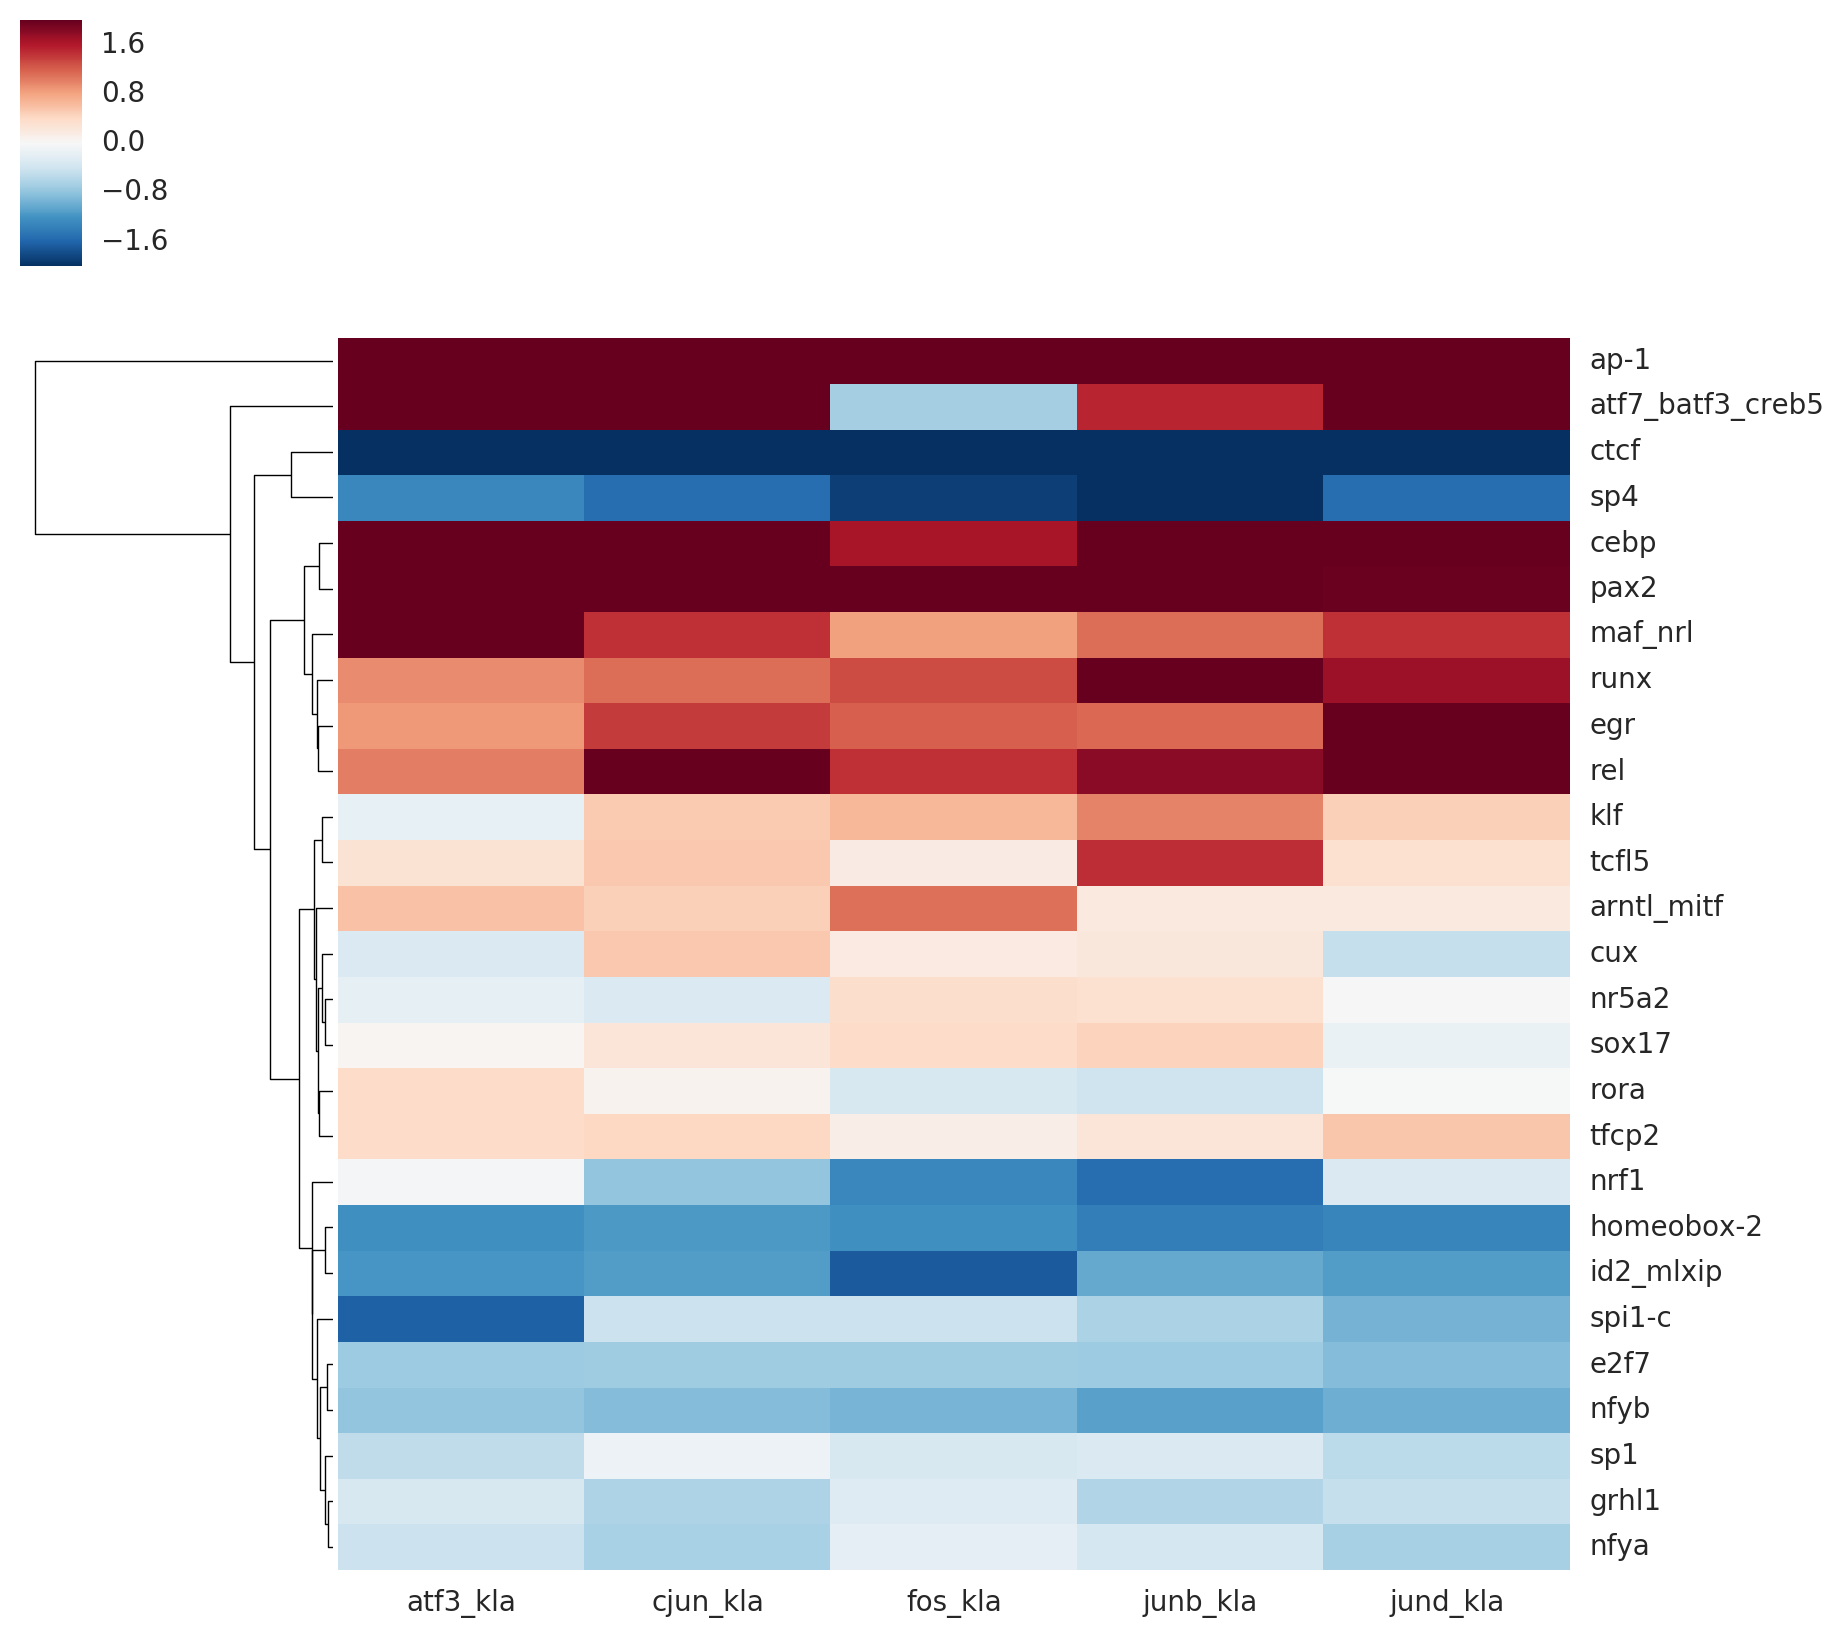

In [30]:
coefficients_frame = pd.DataFrame(factor_meanCoeff_dict)
coefficients_frame.index = standardized_motif_frame.columns.values
for col in coefficients_frame.columns.values:
    sns.distplot(coefficients_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_frame = coefficients_frame[[]]
for col in coefficients_frame:
    coefficients_zscore_frame[col] = scipy.stats.mstats.zscore(coefficients_frame[col].values)

coefficients_zscore_frame.index = coefficients_frame.index.values
coefficients_zscore_frame.columns = coefficients_frame.columns.values

### plot coefficents for vehicle
weight_threshold = 2

for treatment in ['veh', 'kla']:
    data = coefficients_zscore_frame
    data = data[(data.max(axis=1) >= weight_threshold) |
                (data.min(axis=1) < -1 * weight_threshold)
                ][[x for x in coefficients_zscore_frame.columns.values if treatment in x]]

    cg = sns.clustermap(data,
                       vmax=weight_threshold,
                       vmin=weight_threshold,
                       center = 0.0,
                       col_cluster = False,
                       xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );





## Run Logistic Regression using Random Genomic Background

In [24]:
strain = 'C57BL6J'
motif_score_background_frame = pd.read_pickle('motif_score_background_frame_'+  strain + '.pickle')
motif_sequence_background_frame=pd.read_pickle('motif_sequence_background_frame_'+  strain + '.pickle')
motif_strand_background_frame=pd.read_pickle('motif_strand_background_frame_'+  strain + '.pickle')
motif_start_background_frame=pd.read_pickle('motif_start_background_frame_'+  strain + '.pickle')
motif_end_background_fram=pd.read_pickle('motif_end_background_frame_'+  strain + '.pickle')
motif_count_background_frame=pd.read_pickle('motif_count_background_frame_'+  strain + '.pickle')


In [25]:
scaler = preprocessing.StandardScaler()
standardized_motif_randomBackground_frame = pd.DataFrame(scaler.fit_transform(motif_score_background_frame.ix[:,3:]))
standardized_motif_randomBackground_frame.columns = motif_score_background_frame.columns.values[3:]
standardized_motif_randomBackground_frame.index = motif_score_background_frame.index.values

In [26]:
numIterations = 5
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
test_size = 0.5
factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac', 'cebpa', 'pu1', 'p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  



In [57]:
# for monomers using all motifs
strain = 'c57bl6'
background_ratio = 1.0
factor_auc_randomBackground_dict = {}
factor_precision_randomBackground_dict = {}
factor_coeff_randomBackground_dict = {}
factor_prob_randomBackground_dict = {}
factor_meanCoeff_randomBackground_dict = {}
factor_intercept_randomBackground_dict = {}
factor_meanIntercept_randomBackground_dict = {}
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)
        if np.sum(labels) >= 100:
            all_aucs = []
            all_coefficients = []
            all_probs = None
            all_precisions = []
            all_intercepts = []
            for i in range(numIterations):  

                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_split(
                    features, labels, test_size = test_size)

                #  Run classifier
                lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1', n_jobs=-1)

                lr_classifier.fit(training_features, training_labels)
                # retrieve probabilities
                probas_lr = lr_classifier.predict_proba(test_features)

                # score predictions
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probas_lr[:, 1], average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probas_lr[:, 1], average = None)

                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)

                # score all sequences
                probs = lr_classifier.predict_proba(features)[:, 1]

                current_coefficients = lr_classifier.coef_.flatten()
                all_coefficients.append(current_coefficients)
                all_intercepts.append(lr_classifier.intercept_[0])
                
                if all_probs == None:
                    all_probs = probs
                else:
                    all_probs = all_probs + probs
            mean_coefficients = np.mean(all_coefficients, axis=0)
            
            factor_auc_randomBackground_dict[monomer + '_' + treatment]= all_aucs
            factor_precision_randomBackground_dict[monomer + '_' + treatment] = all_precisions
            factor_coeff_randomBackground_dict[monomer + '_' + treatment] = all_coefficients
            factor_prob_randomBackground_dict[monomer + '_' + treatment] = all_probs
            factor_meanCoeff_randomBackground_dict[monomer + '_' + treatment] = mean_coefficients
            factor_intercept_randomBackground_dict[monomer + '_' + treatment] = all_intercepts
            factor_meanIntercept_randomBackground_dict[monomer + '_' + treatment] = np.mean(all_intercepts)
            print(monomer + '_' + treatment,
                  'roc:', np.mean(all_aucs), np.var(all_aucs),
                  'precision:', np.mean(all_precisions), np.var(all_precisions),  
                  'numTestPositives:', np.sum(test_labels)
                 )

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:60: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


atf3_veh roc: 0.91816728501 8.29582174032e-07 precision: 0.91817241071 9.58112881791e-07 numTestPositives: 11013
cjun_veh roc: 0.935657180732 1.26686249457e-06 precision: 0.936579649802 1.58069449326e-06 numTestPositives: 6335
fos_veh roc: 0.937850240275 9.32392644639e-05 precision: 0.928984680608 2.54143015538e-05 numTestPositives: 994
junb_veh roc: 0.789031126555 0.000628494238758 precision: 0.809905610934 0.00100284628026 numTestPositives: 247
jund_veh roc: 0.915046284789 1.0016428653e-06 precision: 0.913799892741 3.13354331701e-06 numTestPositives: 9025
atf3_kla roc: 0.913485383154 8.18063042348e-07 precision: 0.905390702041 1.12480538085e-06 numTestPositives: 17327
cjun_kla roc: 0.935614331664 2.87843855014e-06 precision: 0.932644523746 2.66172941457e-06 numTestPositives: 8068
fos_kla roc: 0.940386414823 1.07584024102e-06 precision: 0.93639601974 2.12932906029e-06 numTestPositives: 10733
junb_kla roc: 0.947683091345 2.79946805178e-07 precision: 0.946582913812 1.01107202184e-06 num

In [58]:
factor_auc_dict_avg = {}
factor_precision_dict_avg = {}
background_ratio = 1.0
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        print(monomer, treatment)
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) >= 100:
            all_aucs = []
            all_coefficients = []
            all_probs = None
            all_precisions = []
            all_intercepts = []
            for i in range(numIterations):  
                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_GC_matched_split(
                    features, labels, test_size = test_size, tolerance = 0.01)
                
                weights = factor_meanCoeff_randomBackground_dict[monomer + '_' + treatment]
                intercept = factor_meanIntercept_randomBackground_dict[monomer + '_' + treatment]
                scores = np.dot(test_features, weights) + intercept
                probs = np.array([signmoid(x) for x in scores])
                
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, probs, average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, probs, average = None)
    
                all_aucs.append(current_roc_auc)
                all_precisions.append(current_precision)
            
            
            factor_auc_dict_avg[monomer + '_' + treatment] = all_aucs
            factor_precision_dict_avg[monomer + '_' + treatment] = all_precisions

                
            print(monomer + '_' + treatment,
              'roc:', np.mean(all_aucs), np.var(all_aucs),
              'precision:', np.mean(all_precisions), np.var(all_precisions),  
              'numTestPositives:', np.sum(test_labels)
             )

atf3 veh


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh roc: 0.920252989948 2.19234410586e-06 precision: 0.932005676491 1.46492876375e-06 numTestPositives: 11013
cjun veh
cjun_veh roc: 0.937235004052 3.18956481215e-06 precision: 0.948137199232 3.9431860682e-06 numTestPositives: 6335
fos veh
fos_veh roc: 0.954465928661 1.13813568779e-05 precision: 0.948583718195 3.7479007524e-05 numTestPositives: 994
junb veh
junb_veh roc: 0.901857107633 5.36535379245e-05 precision: 0.923249162825 5.40105224282e-05 numTestPositives: 247
jund veh
jund_veh roc: 0.920282866309 1.41280525149e-06 precision: 0.932741315158 3.26414462608e-06 numTestPositives: 9025
atf3 kla
atf3_kla roc: 0.915665159317 1.94035071069e-06 precision: 0.923356934371 2.16301654408e-06 numTestPositives: 17327
cjun kla
cjun_kla roc: 0.939583741434 1.11215954056e-06 precision: 0.946897626338 2.22800863901e-06 numTestPositives: 8068
fos kla
fos_kla roc: 0.939753315653 9.33256128604e-07 precision: 0.947542342651 1.12243758919e-06 numTestPositives: 10733
junb kla
junb_kla roc: 0.94985

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


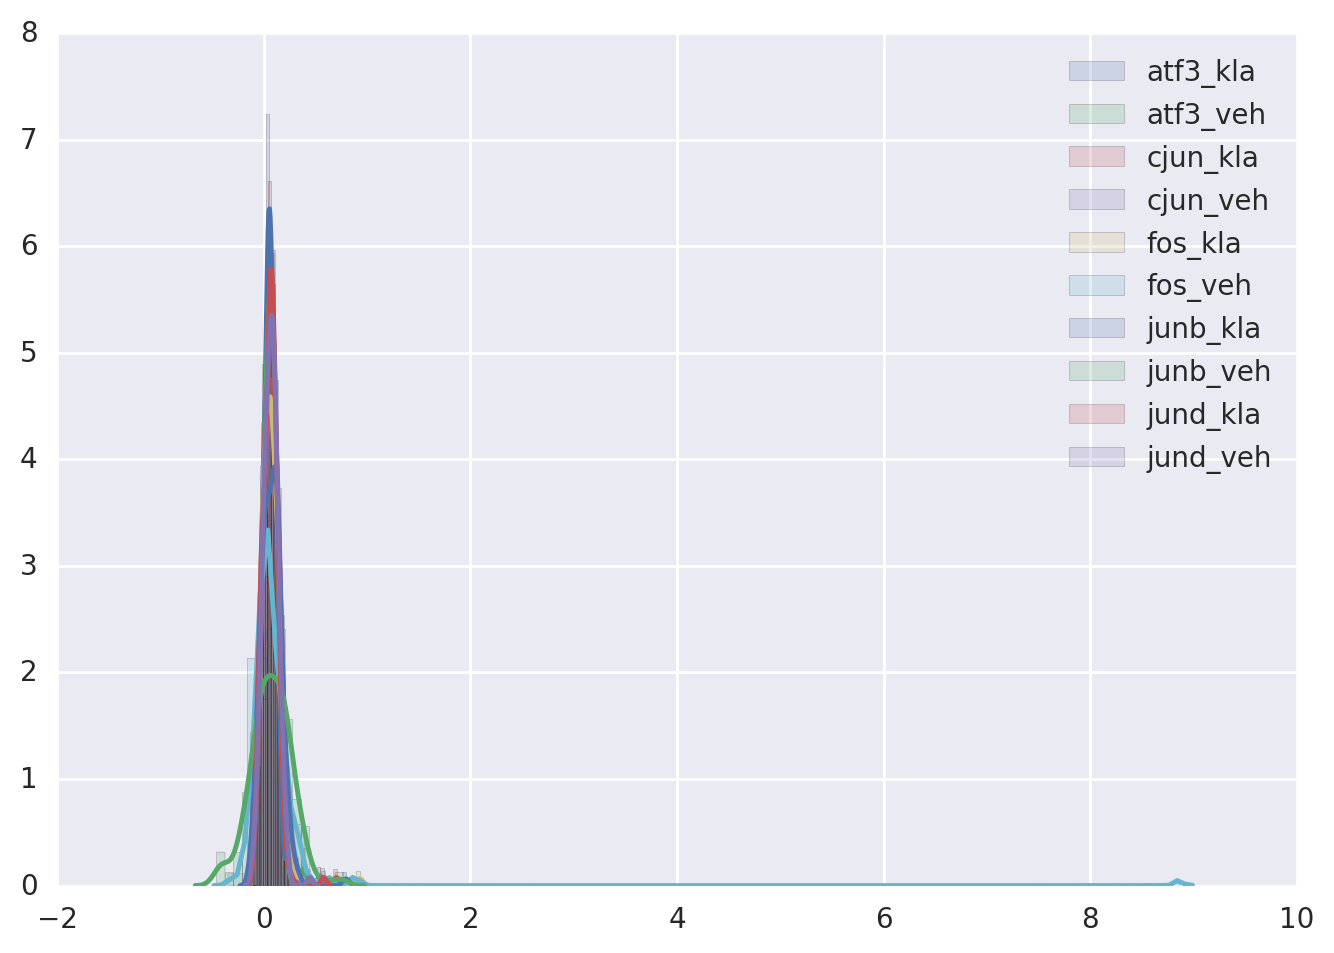

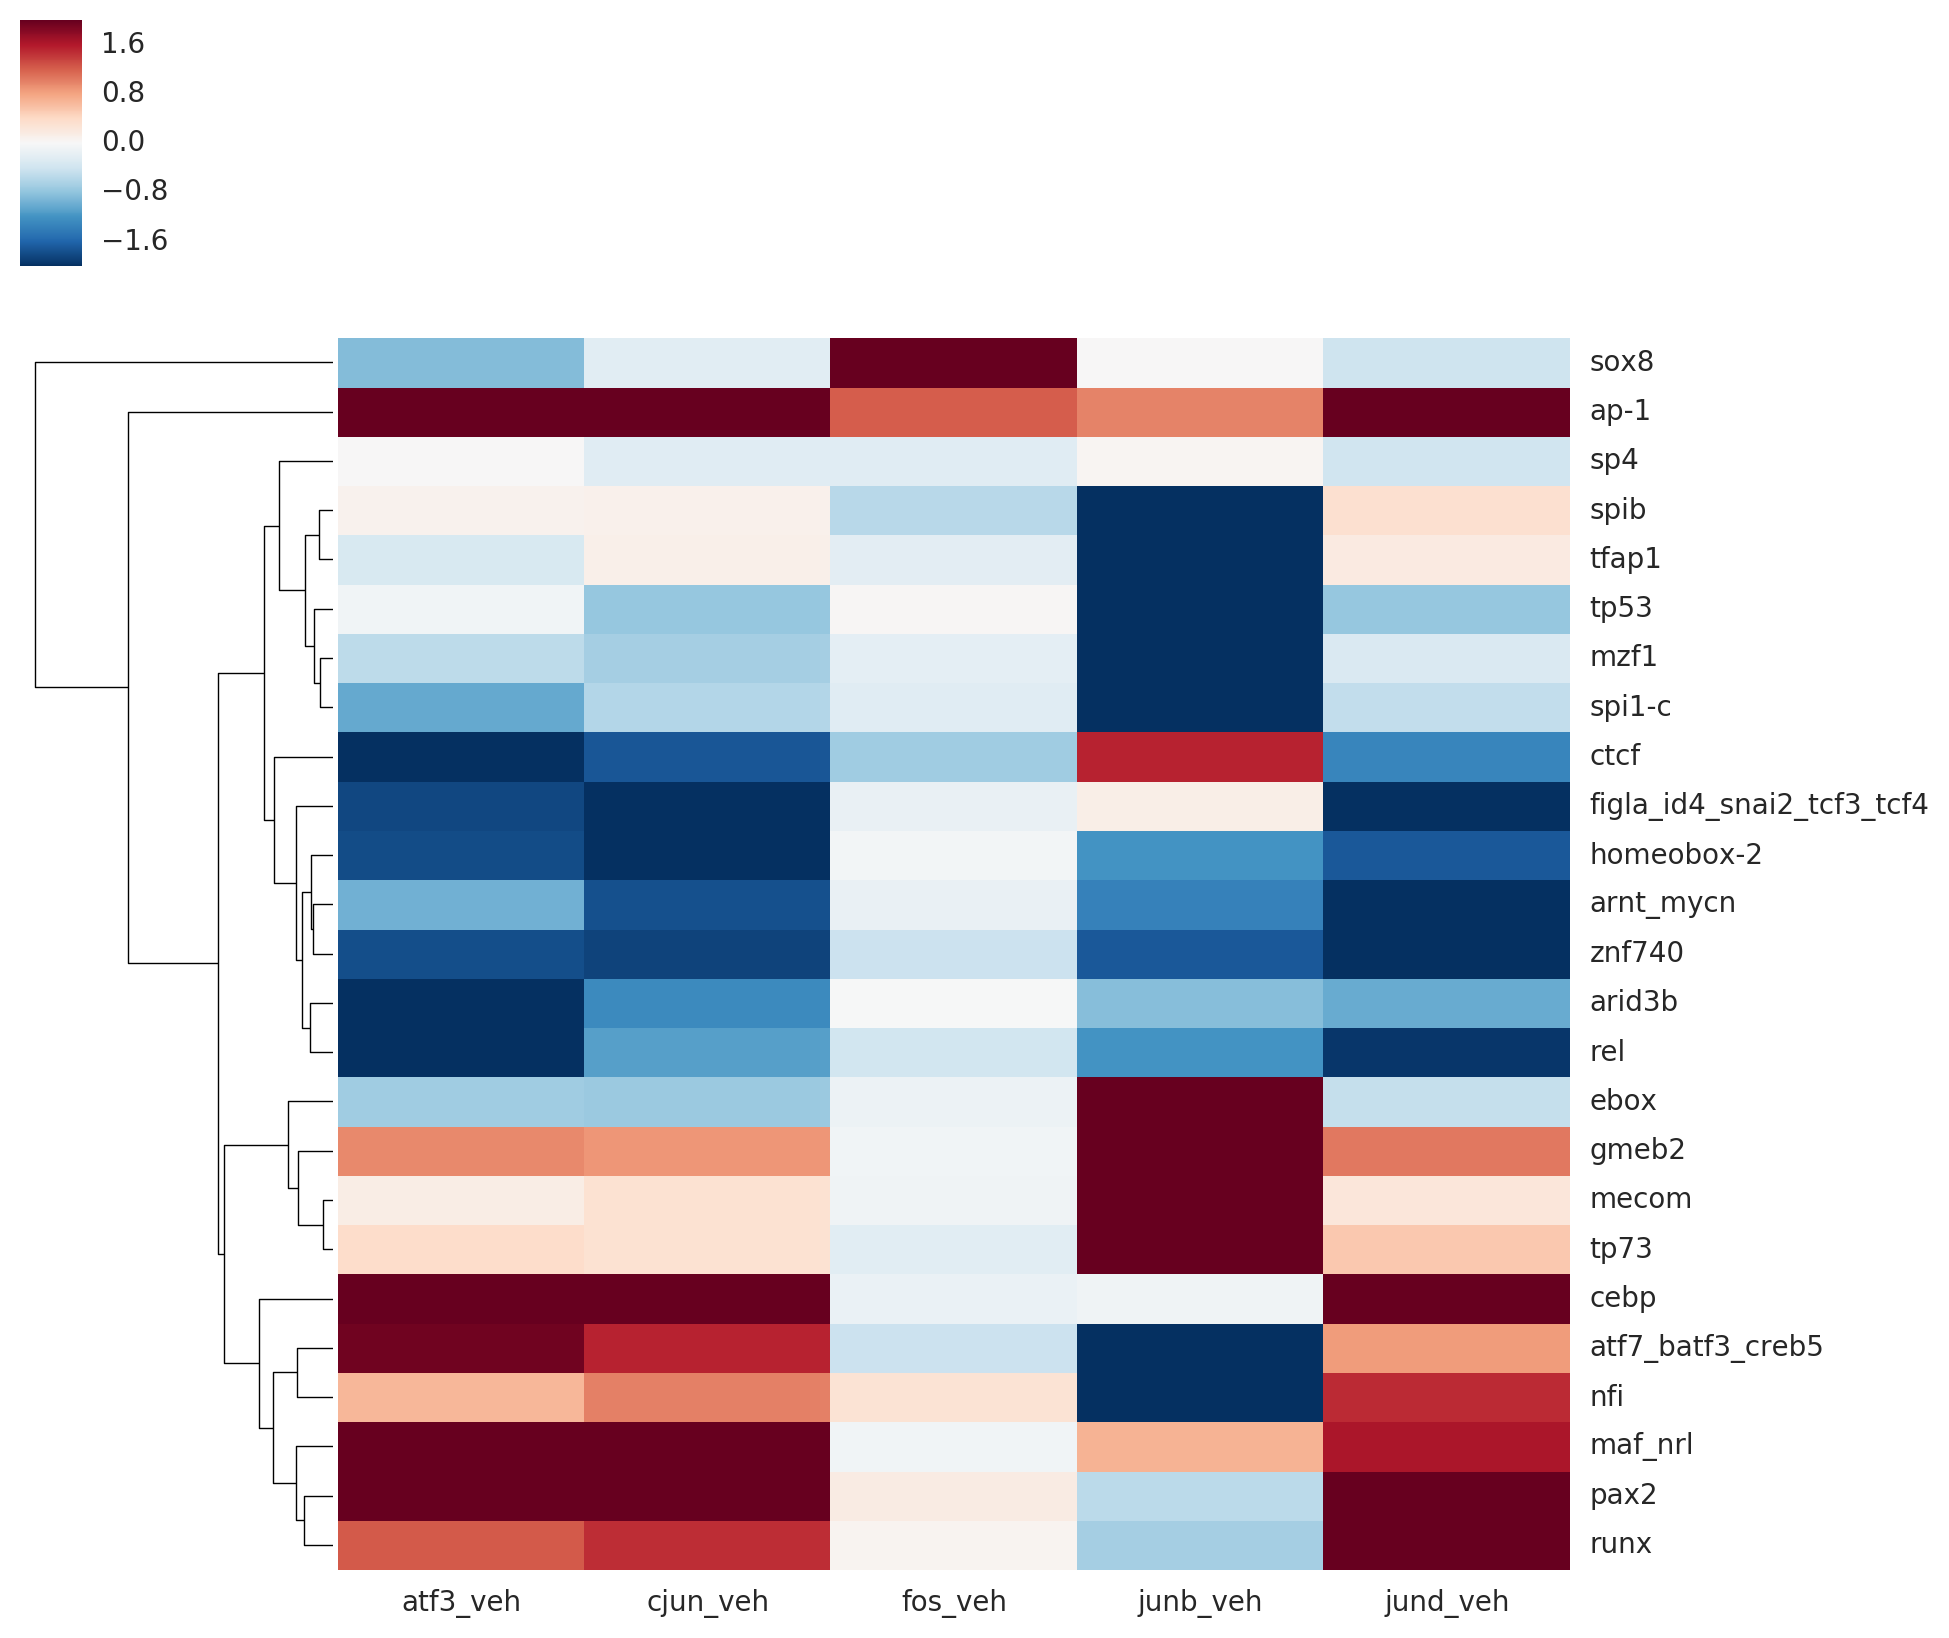

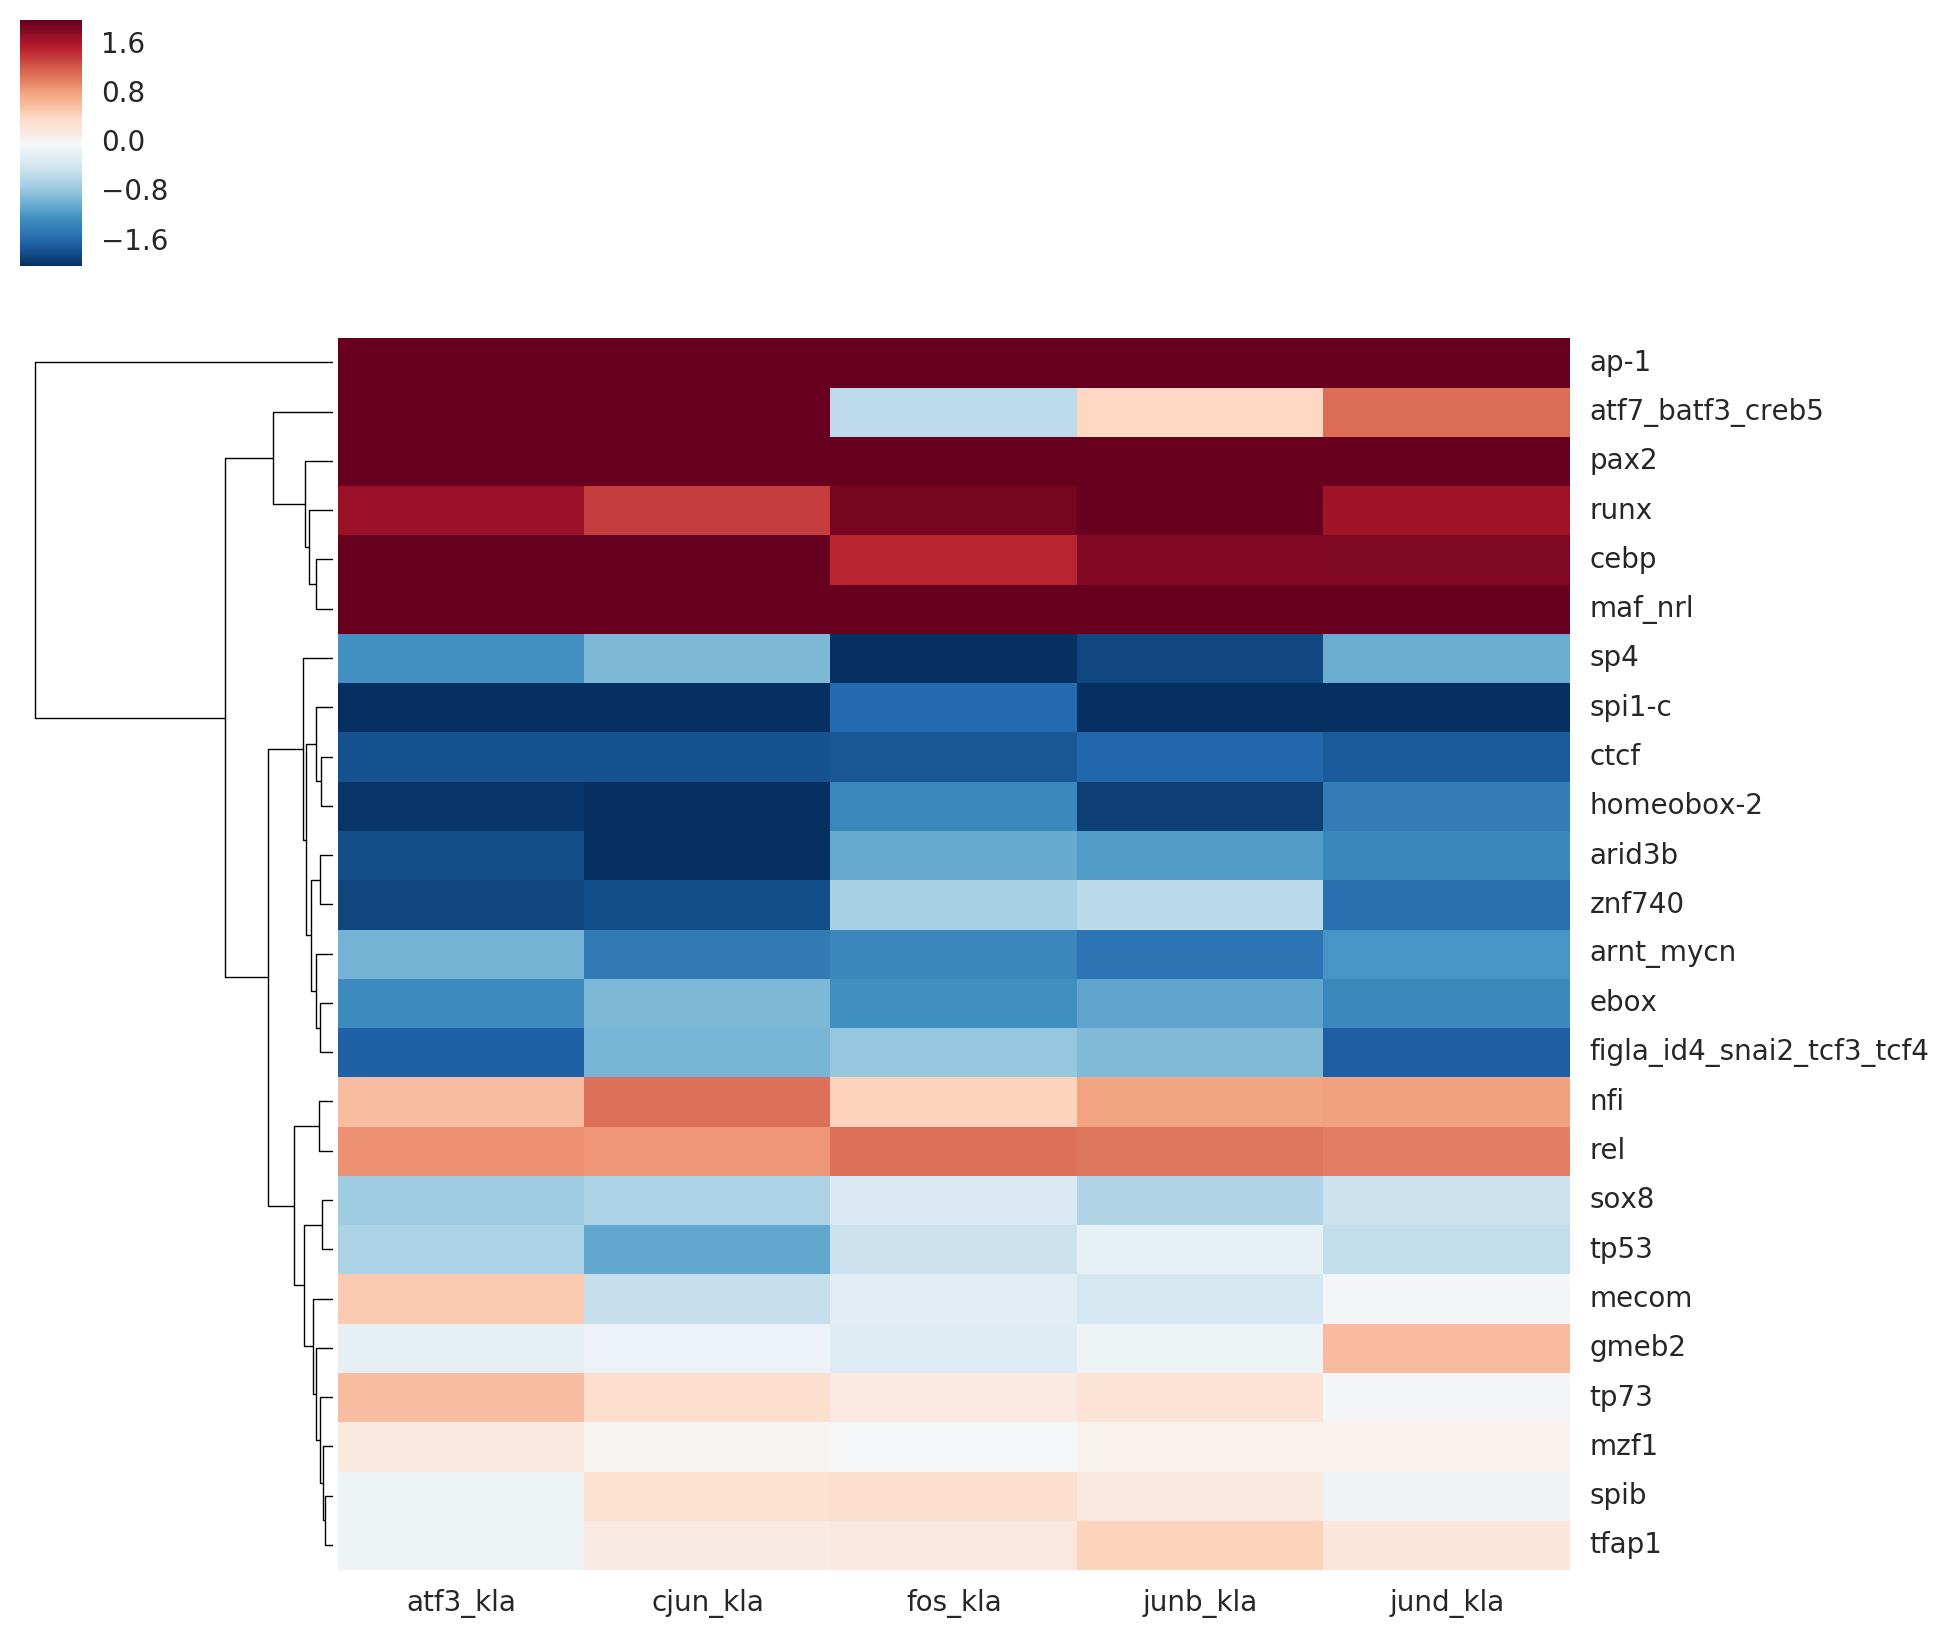

In [59]:
coefficients_randomBackground_frame = pd.DataFrame(factor_meanCoeff_randomBackground_dict)
coefficients_randomBackground_frame.index = standardized_motif_randomBackground_frame.columns.values
for col in coefficients_randomBackground_frame.columns.values:
    sns.distplot(coefficients_randomBackground_frame[col].values, label=col, hist_kws={'alpha':0.2})

plt.legend()

# transform_coffcients into z-scores
coefficients_zscore_randomBackground_frame = coefficients_randomBackground_frame[[]]
for col in coefficients_randomBackground_frame:
    coefficients_zscore_randomBackground_frame[col] = scipy.stats.mstats.zscore(coefficients_randomBackground_frame[col].values)

coefficients_zscore_randomBackground_frame.index = coefficients_randomBackground_frame.index.values
coefficients_zscore_randomBackground_frame.columns = coefficients_randomBackground_frame.columns.values

### plot coefficents for vehicle
weight_threshold = 2

for treatment in ['veh', 'kla']:
    data = coefficients_zscore_randomBackground_frame
    data = data[(data.max(axis=1) >= weight_threshold) |
                (data.min(axis=1) < -1 * weight_threshold)
                ][[x for x in coefficients_zscore_randomBackground_frame.columns.values if treatment in x]]

    cg = sns.clustermap(data,
                       vmax=weight_threshold,
                       vmin=weight_threshold,
                       center = 0.0,
                       col_cluster = False,
                       xticklabels=[x.replace('c57bl6_','') for x in data.columns.values])
    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0, );




## Comparioson of Random Background Coefficients Vs Open Chromatin background Coefficients

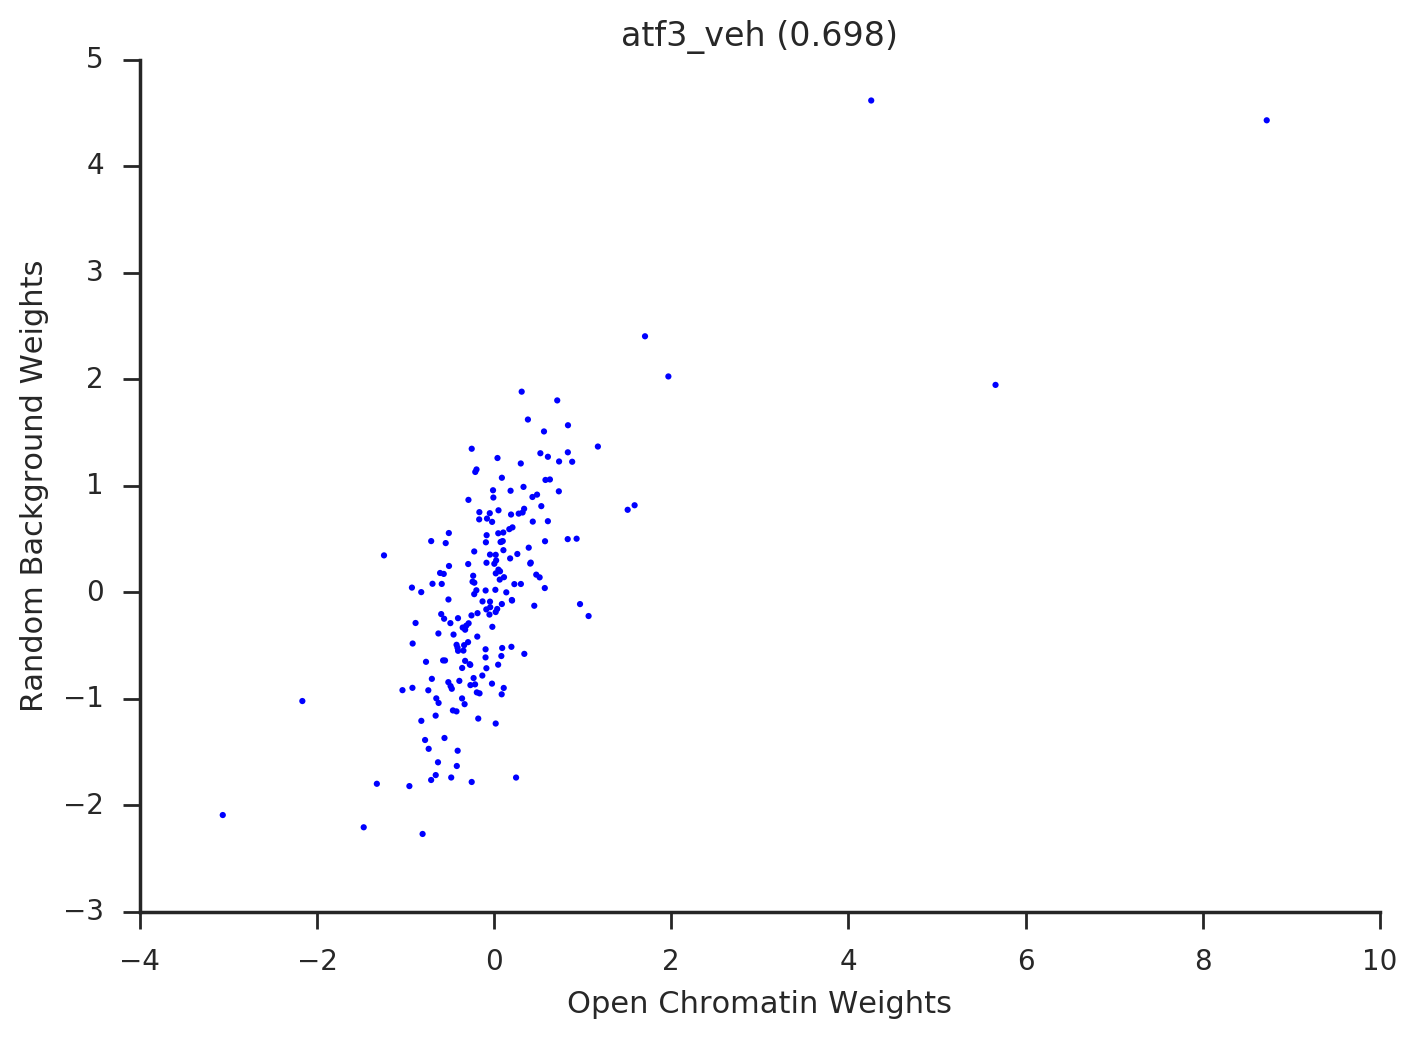

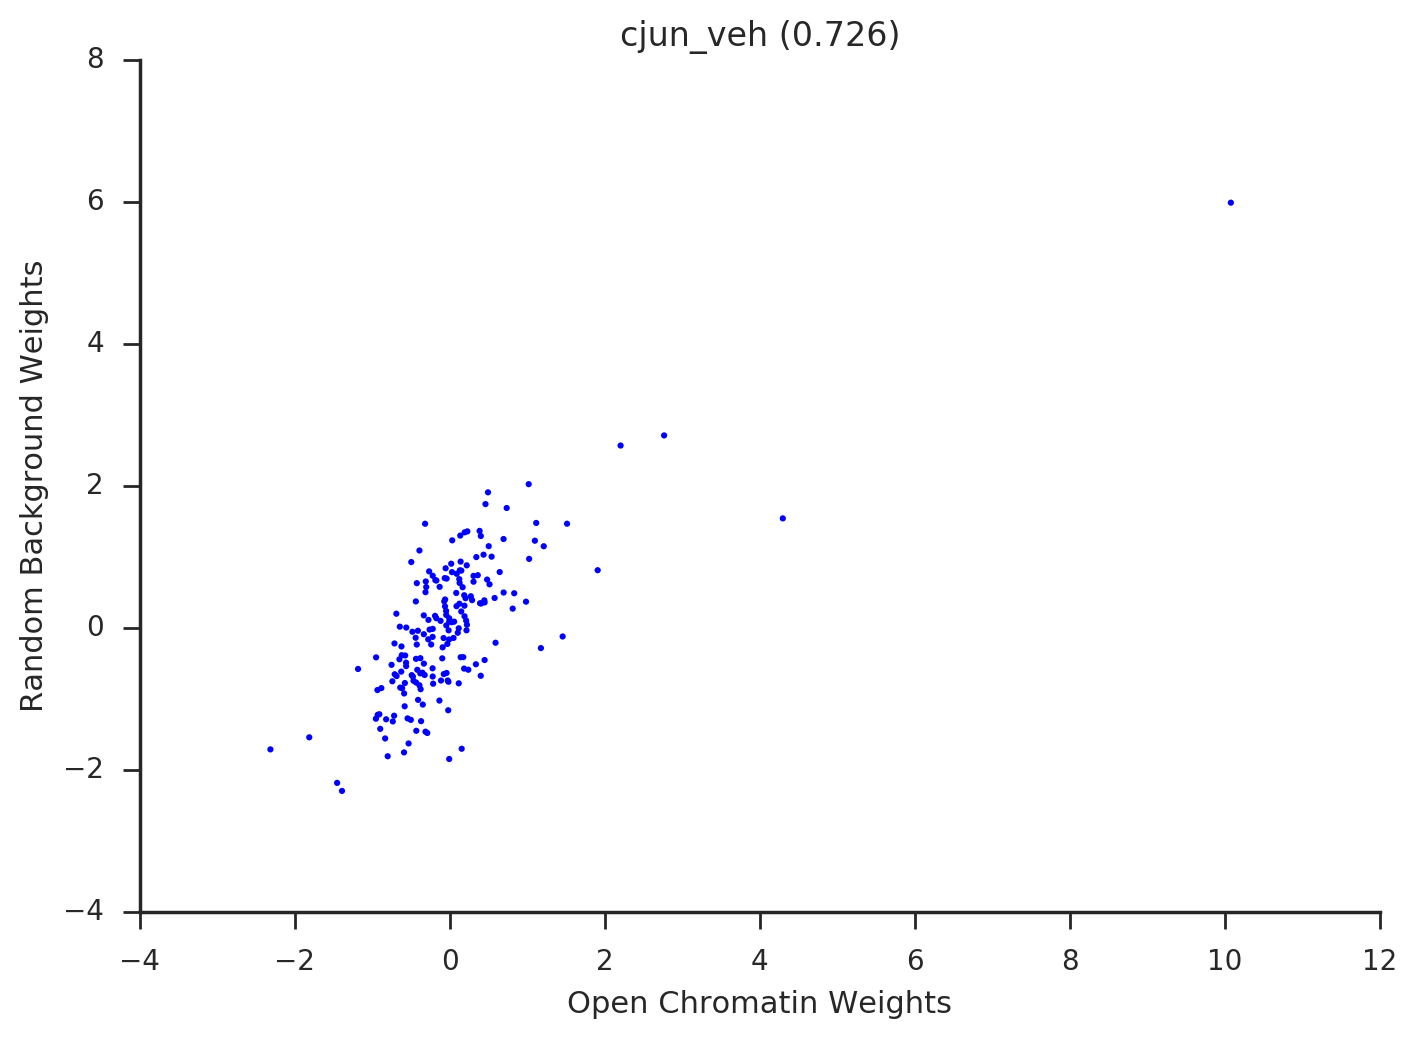

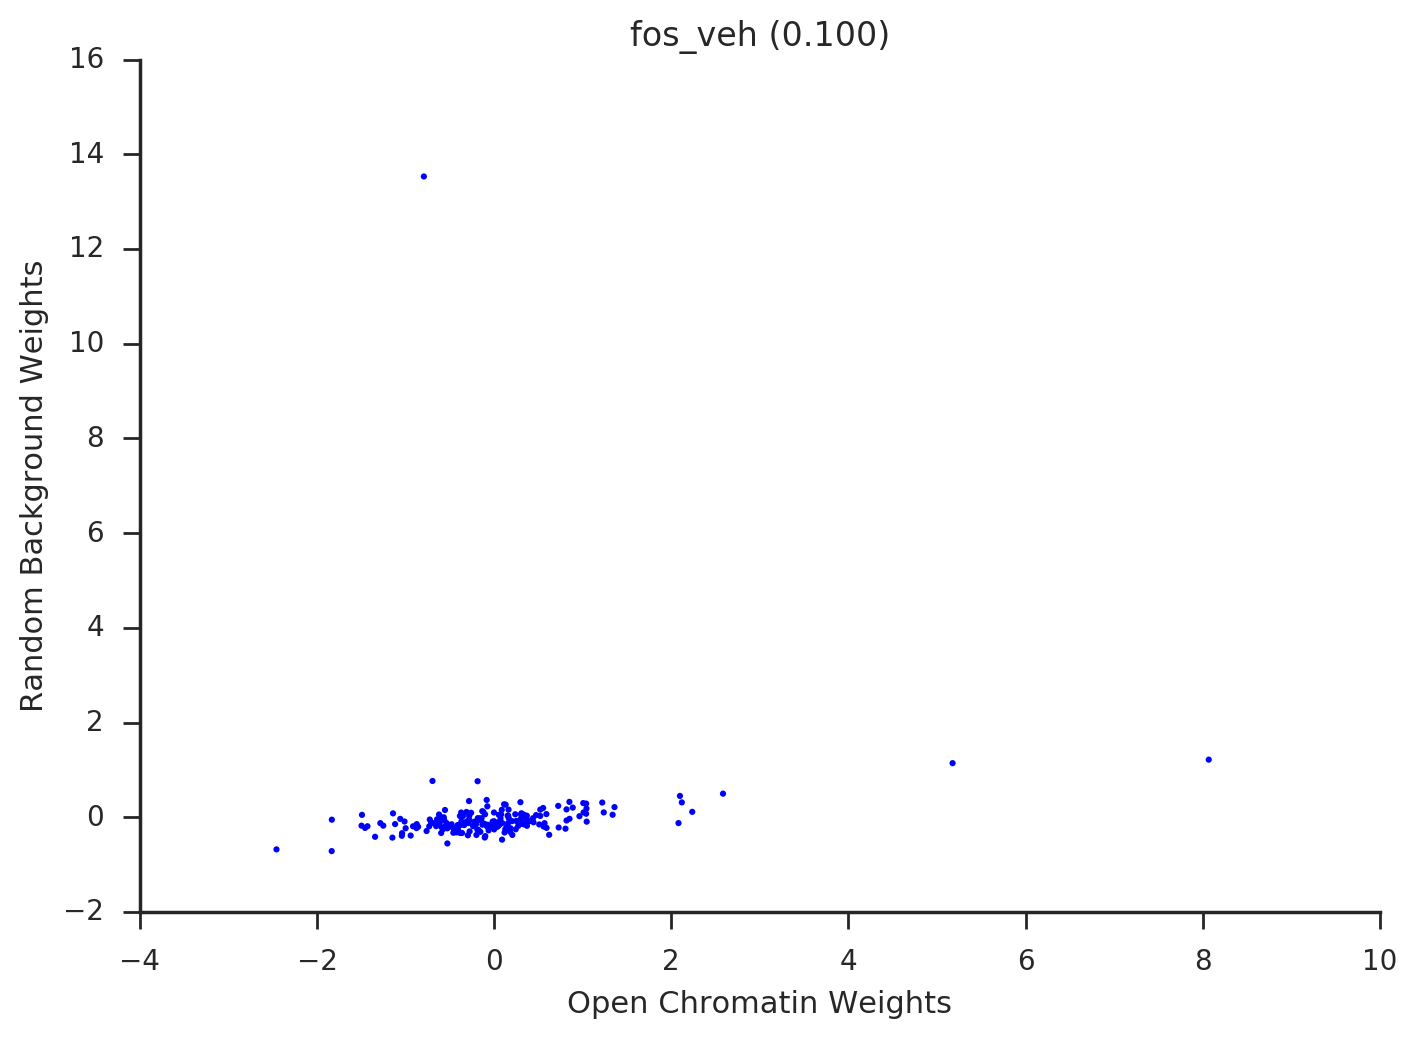

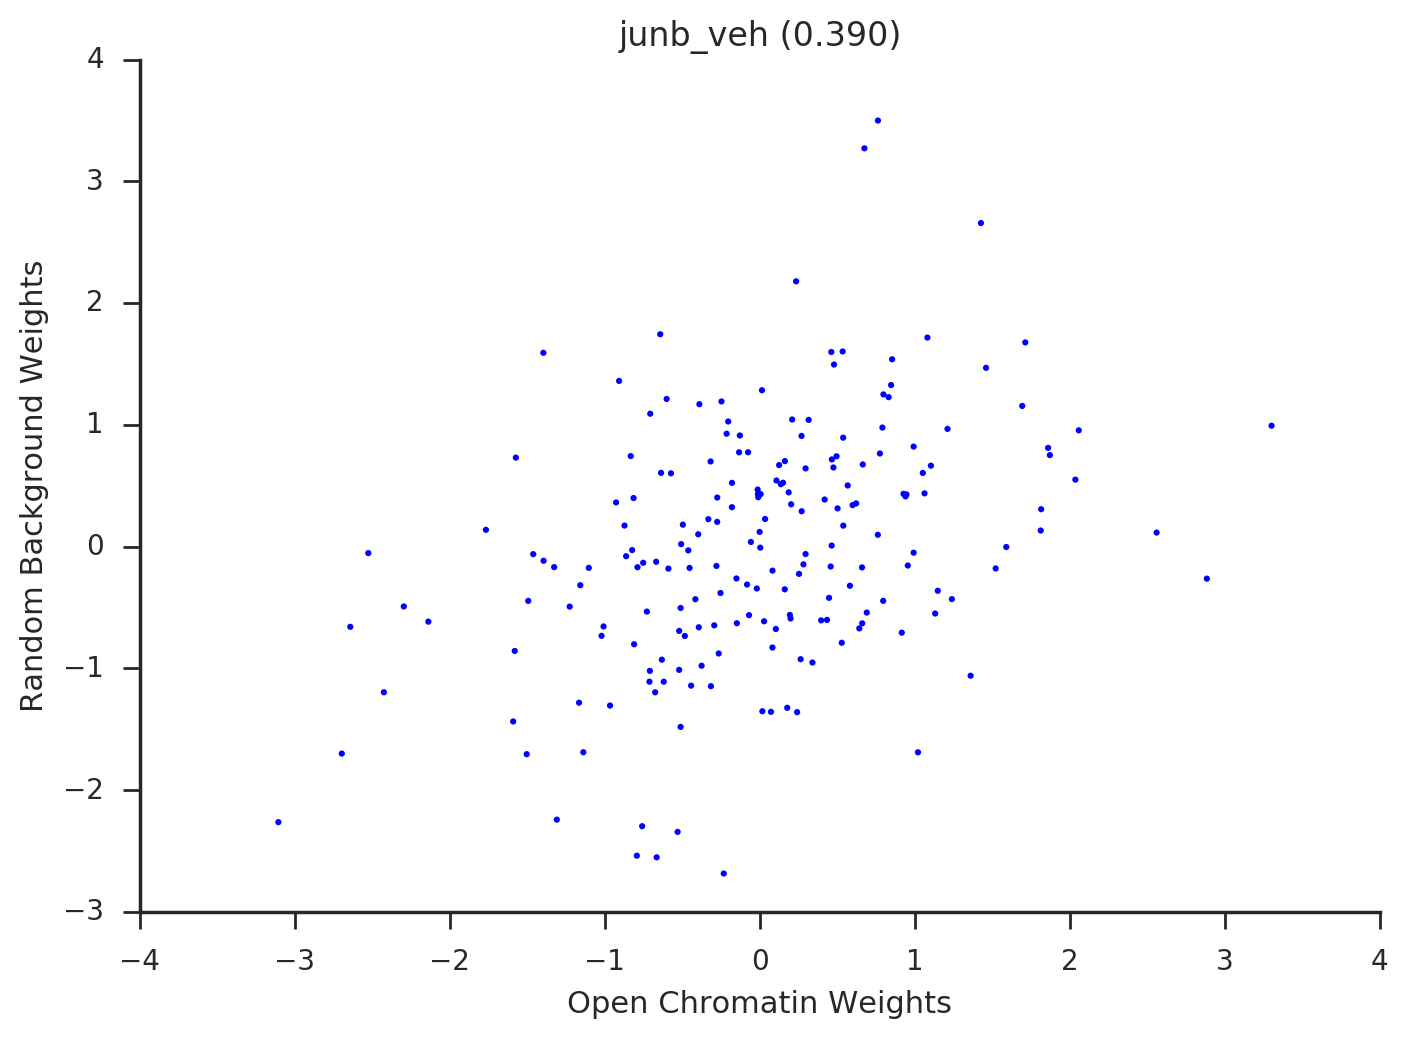

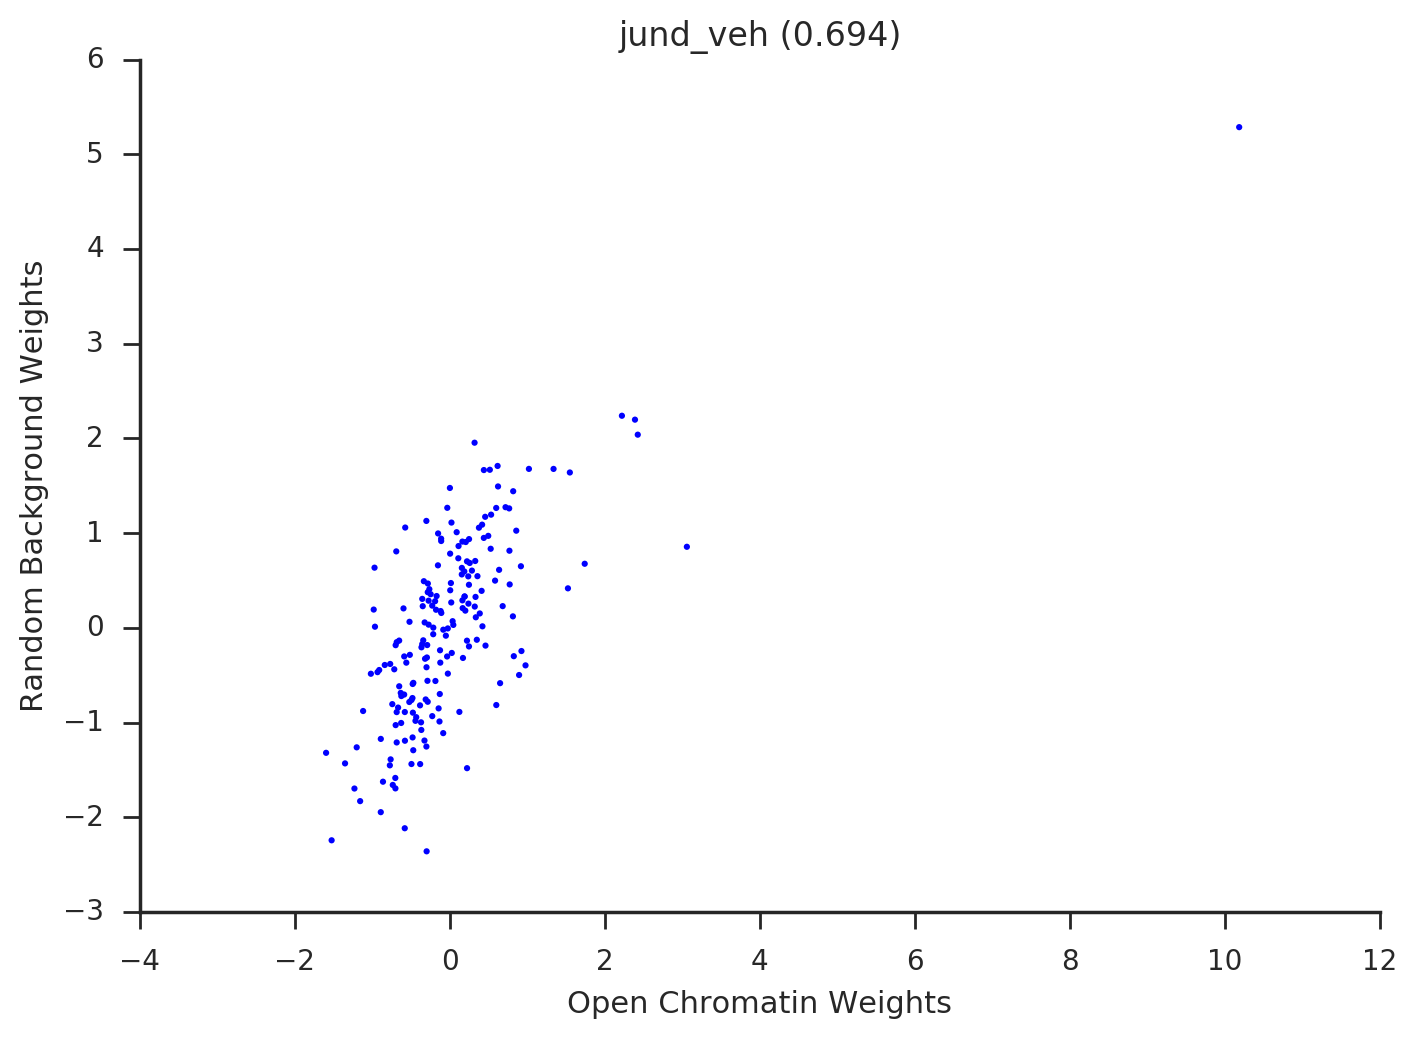

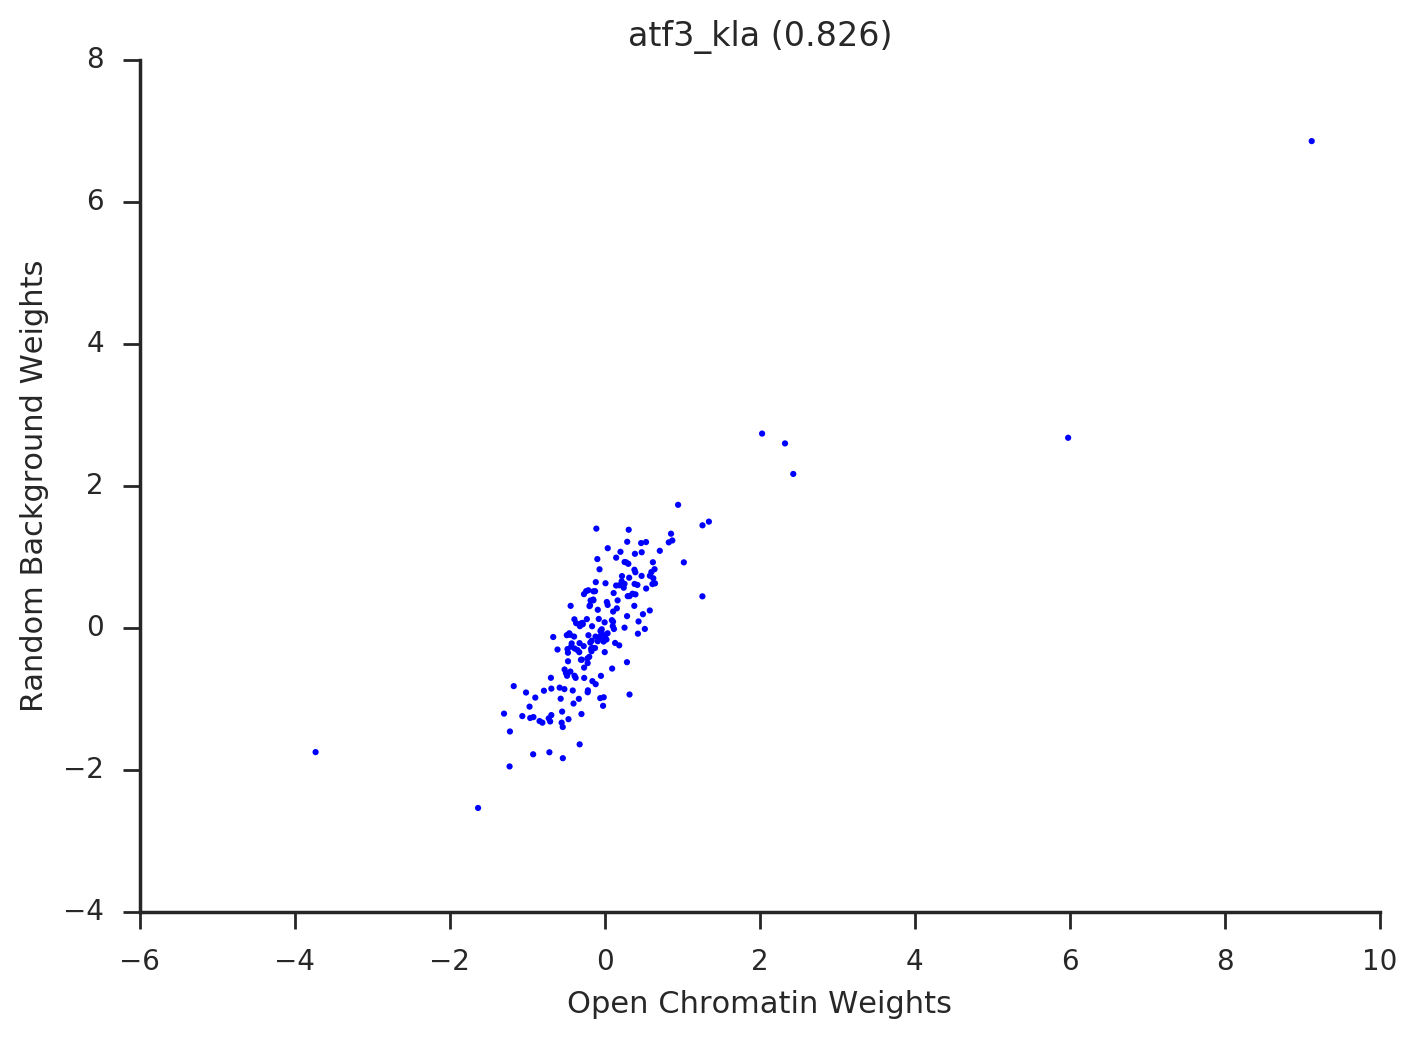

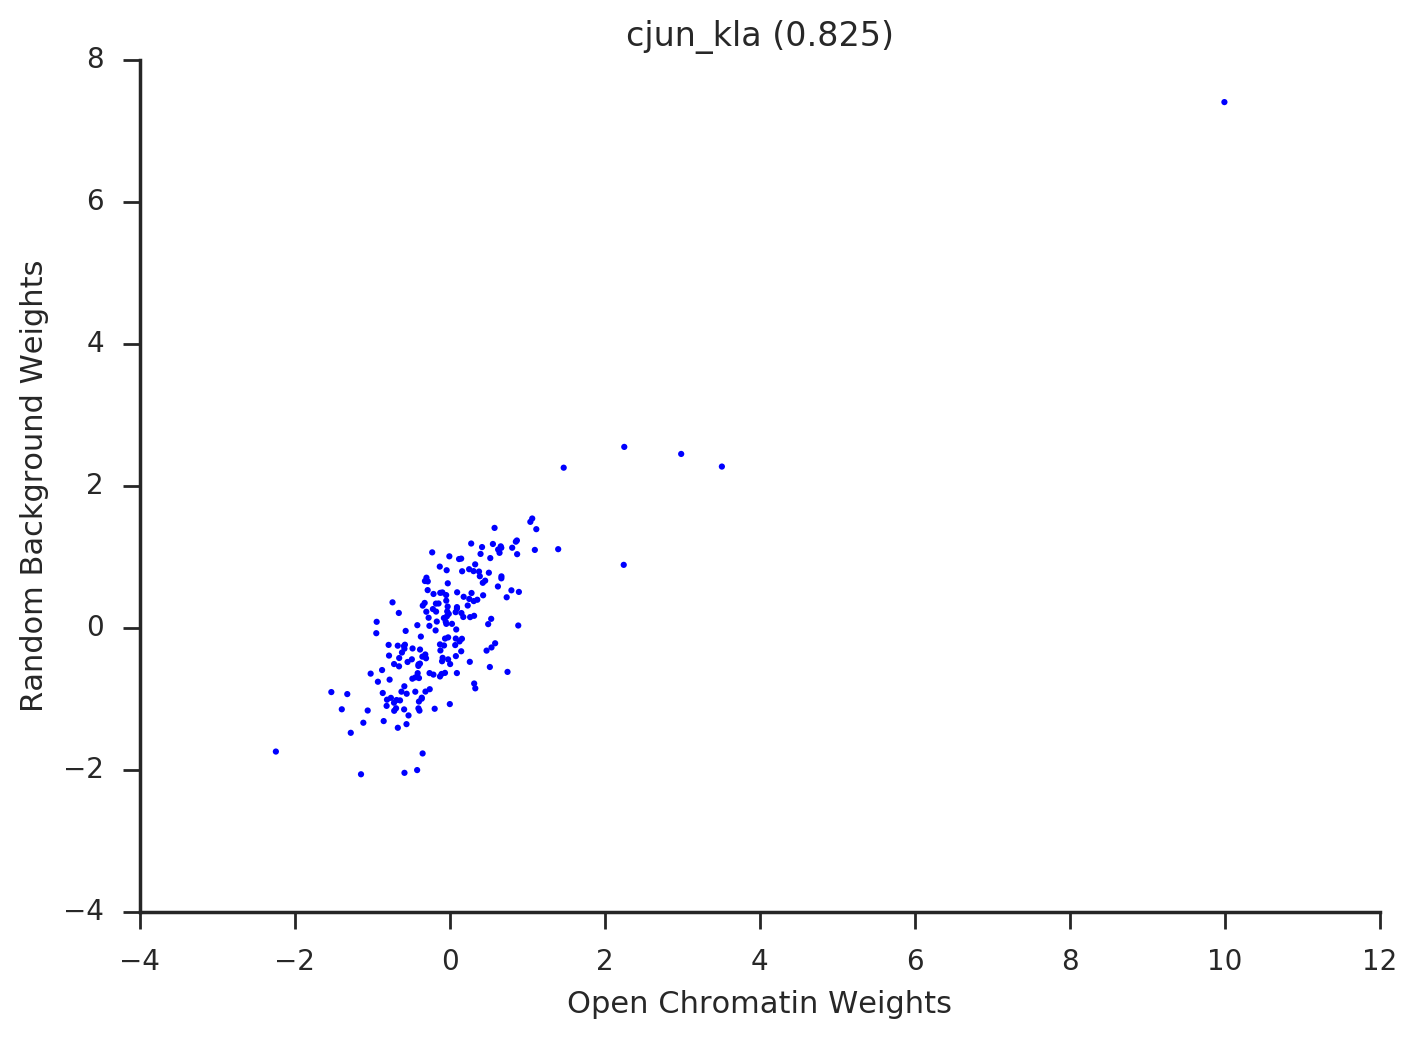

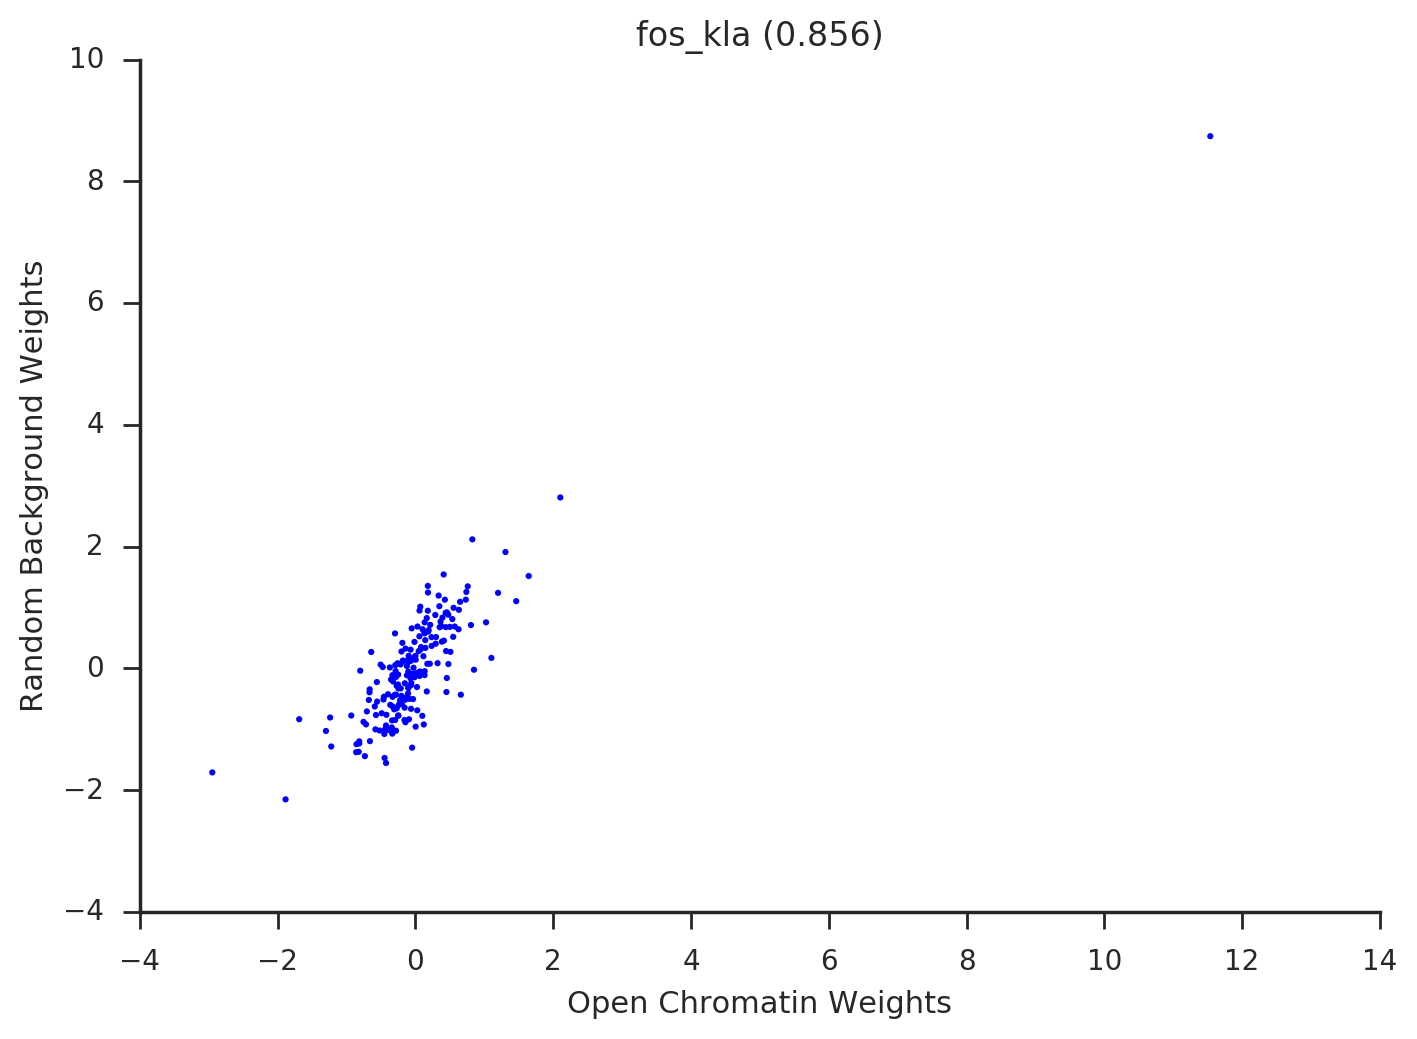

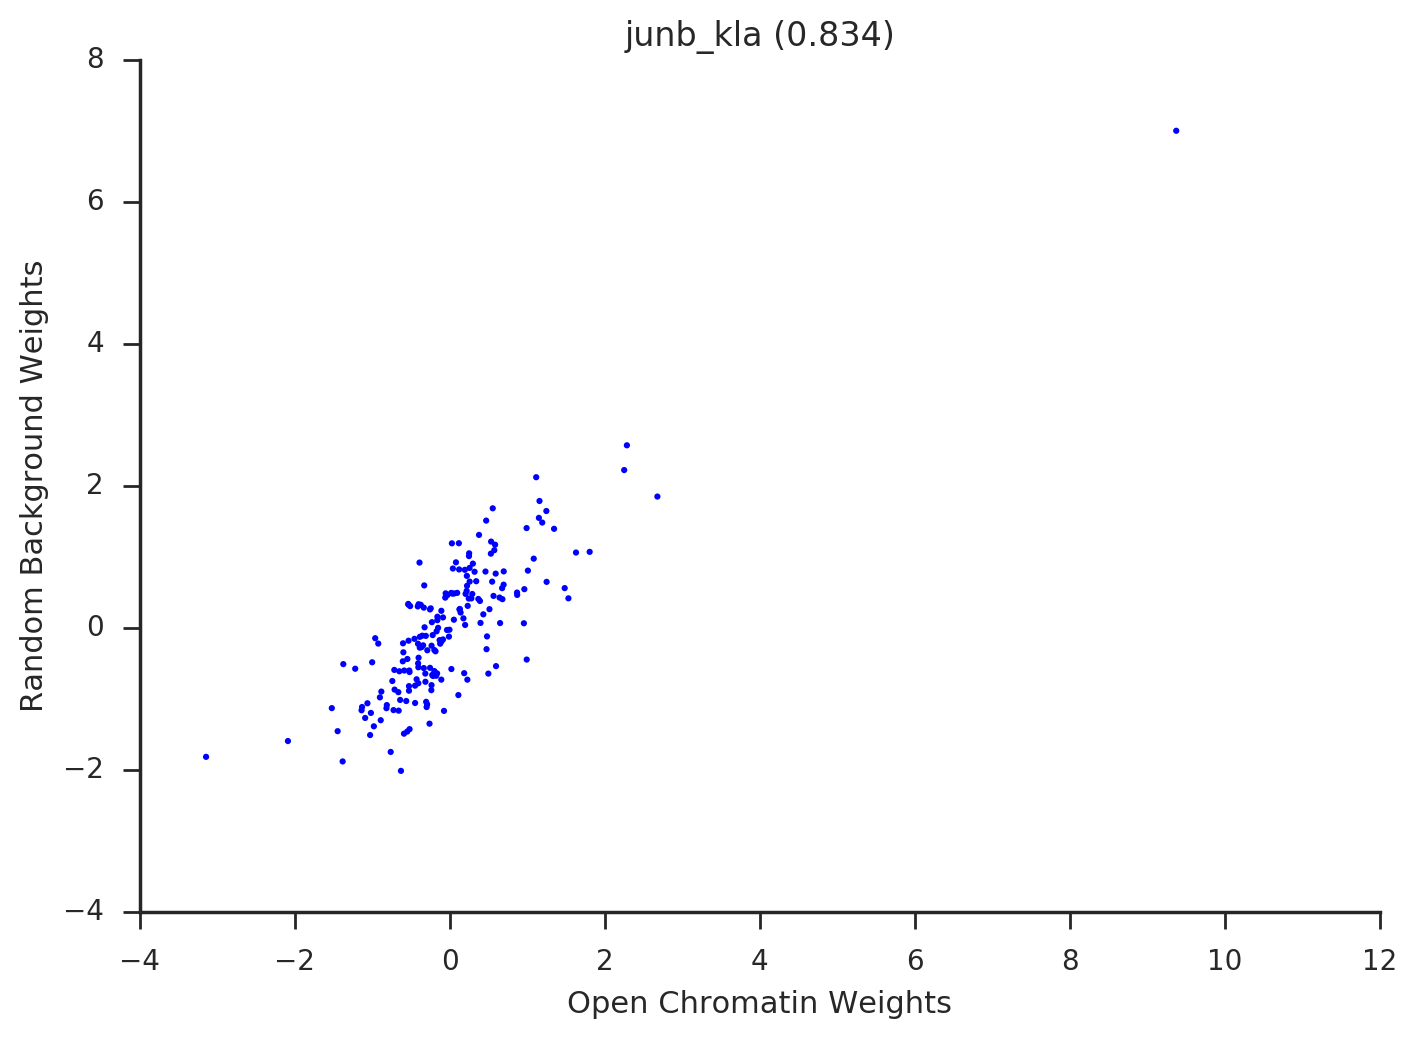

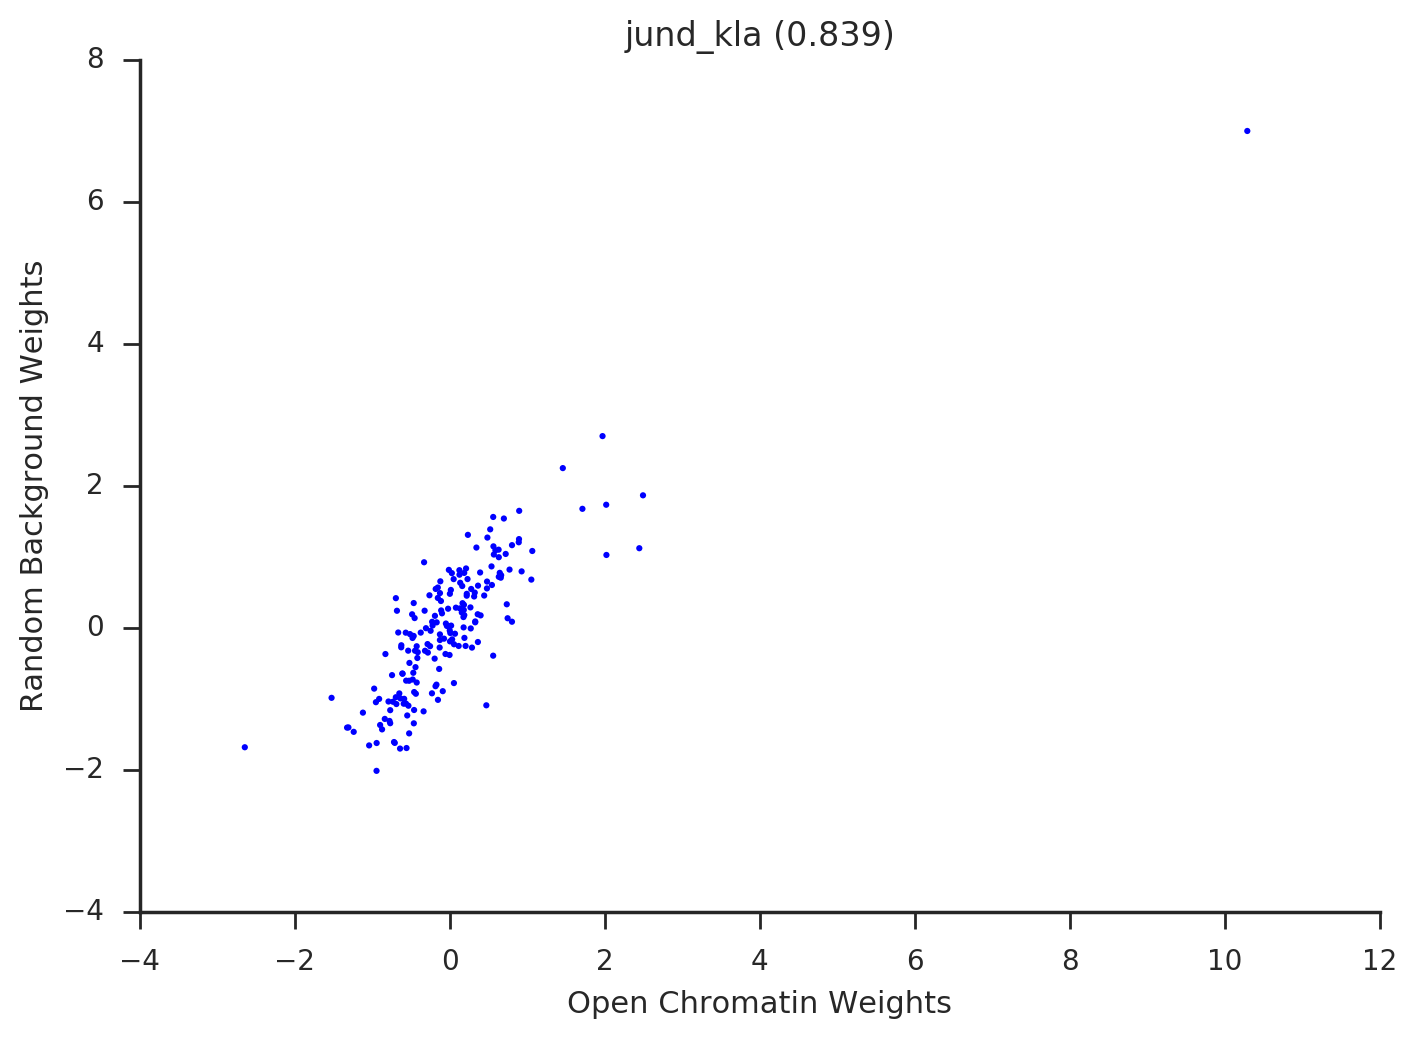

In [71]:
for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        chrom_weights = coefficients_zscore_frame[monomer + '_' + treatment]
        randomBackground_weights = coefficients_zscore_randomBackground_frame[monomer + '_' + treatment]

        pearson, pval = scipy.stats.pearsonr(chrom_weights, randomBackground_weights)
        with sns.axes_style('ticks'):
#             data = pd.DataFrame({'Open Chromatin': chrom_weights, 
#                  'Random Background': randomBackground_weights})
#             sns.residplot(data = data, 
#                 x = 'Open Chromatin',
#                 y= 'Random Background')
            plt.scatter(chrom_weights, randomBackground_weights, marker = '.', edgecolors='None')
            plt.xlabel('Open Chromatin Weights')
            plt.ylabel('Random Background Weights')
            plt.title(monomer + '_' + treatment + ' (' + str(pearson)[:5] + ')')
            sns.despine()
            plt.show()
        



## Run gkmSVM against Random Genomic Background

In [72]:
!if [ ! -d ./gkmsvm_files ]; then mkdir ./gkmsvm_files; fi
! rm ./gkmsvm_files/*

In [ ]:
### read in target sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  
### read in background sequences
with open('./C57BL6J_background.fa') as f:
    data = f.readlines()

for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()  

In [ ]:
### for all peaks in vehicle using gapped k-mers on balanced data
### write script
background_ratio = 1.0
for treatment in ['veh', 'kla']:
    script_file = open('gkmsvm_' + treatment + '_randomBackground.sh', 'w')
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                # split data into training and test sets
                training_features, test_features, training_labels, test_labels = get_split(
                    features, labels, test_size = test_size)

                # create fasta files for positive and negative sequences
                training_positive_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_positive_balanced_' +str(iteration) + '.fa'
                training_negative_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_negative_balanced_' +str(iteration) + '.fa'
                training_shortNegative_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_training_shortNegative_balanced_' +str(iteration) + '.fa'


                training_positive_file = open(training_positive_path,'w' )
                training_negative_file = open(training_negative_path,'w' )
                training_shortNegative_file = open(training_shortNegative_path,'w' )
                test_path = './gkmsvm_files/' + monomer + '_' + treatment+ '_test_balanced_' + str(iteration) + '.fa'

                test_file = open(test_path,'w')

                numPositiveSeqs = np.sum(training_labels)
                count=0
                for i in range(len(training_labels)):
                    index = training_labels.index[i]
                    label = training_labels[i]
                    seq = _id_sequence_dict[index]

                    if label == True:
                        training_positive_file.write('>' + index + '\n')
                        training_positive_file.write(seq + '\n')
                    else:
                        if count < numPositiveSeqs:
                            training_shortNegative_file.write('>' + index + '\n')
                            training_shortNegative_file.write(seq + '\n')
                        training_negative_file.write('>' + index + '\n')
                        training_negative_file.write(seq + '\n')
                        count+=1

                for i in range(len(test_labels)):
                    index = test_labels.index[i]
                    label = test_labels[i]
                    seq = _id_sequence_dict[index]
                    test_file.write('>' + index + '\n')
                    test_file.write(seq + '\n')

                training_positive_file.close()
                training_negative_file.close()
                training_shortNegative_file.close()
                test_file.close()

                #  Run classifier
                model_prefix = './gkmsvm_files/' + monomer + '_' + treatment + '_' +str(iteration) + '_balanced'
                model_path = model_prefix + '.model.txt'
                results_path = model_prefix + '_results.txt'

                script_file.write('(gkmtrain '+ training_positive_path + ' ' + training_shortNegative_path + ' ' + model_prefix +
                          ' -T 16 -m 64000;')
                if iteration == (numIterations - 1):
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 4)\n')
                else:
                    script_file.write('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 4)&\n')
                

    script_file.close()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


atf3_veh
cjun_veh
fos_veh
junb_veh
jund_veh
atf3_kla


In [ ]:
%%bash
chmod a+x ./gkmsvm_veh_balanced.sh 
./gkmsvm_veh_balanced.sh

In [ ]:
%%bash
chmod a+x ./gkmsvm_kla_balanced.sh 
./gkmsvm_kla_balanced.sh

In [ ]:
### for all peaks in vehicle using gapped k-mers on balanced data
### read performance
factor_auc_dict_gkmSVM = {}
factor_precision_dict_gkmSVM = {}

for treatment in ['veh', 'kla']:
    for monomer in ap1_members:
        target_indices = summary_frame[summary_frame[strain + '_' + monomer + '_' + treatment] > 0.0].index.values
        target_features = standardized_motif_frame[standardized_motif_frame.index.isin(target_indices)]
        
        background_indices = motif_score_background_frame[
            motif_score_background_frame['Factors'] == strain + '_' + monomer + '_' + treatment + '-background'].index.values
        # select subset of background indices to use
        shuffle(background_indices)
        background_indices = background_indices[:background_ratio*len(target_indices)]
        background_features = standardized_motif_randomBackground_frame[standardized_motif_randomBackground_frame.index.isin(background_indices)]
        
        # merge target and background features together 
        features = pd.concat([target_features, background_features])
        labels = pd.Series(data = [True] * len(target_indices) + [False] * len(background_indices),
                           index = features.index.values)

        if np.sum(labels) > 100:
            print(monomer + '_' + treatment)
            all_aucs = []
            all_precisions = []
            for iteration in range(numIterations):  
                model_prefix = './gkmsvm_files/' + monomer  + '_' + treatment+ '_' +str(iteration) + '_balanced'
                results_path = model_prefix + '_results.txt'


                index_score_dict = {} #{peakID: gkmSVM score}
                with open(results_path) as f:
                    data = f.readlines()
                for line in data:
                    tokens=line.strip().split()
                    score = float(tokens[1])
                    index = tokens[0]
                    index_score_dict[index] = score
                # define true labels
                index_label_dict = dict(zip(labels.index.values, labels.values))

                sorted_indices = sorted(index_score_dict.keys())

                sorted_scores = np.array([index_score_dict[x] for x in sorted_indices])
                test_labels = np.array([index_label_dict[x] for x in sorted_indices])

                min_score = np.min(sorted_scores)
                if min_score < 0:
                    normalized_scores = sorted_scores + abs(min_score)
                normalized_scores = normalized_scores/np.max(normalized_scores)

                # score predictions          
                current_roc_auc = sklearn.metrics.roc_auc_score(test_labels, normalized_scores, average = None)
                current_precision = sklearn.metrics.average_precision_score(test_labels, normalized_scores, average = None)
                all_precisions.append(current_precision)
                all_aucs.append(current_roc_auc)

            # average scoring metrics 

            mean_roc_auc = np.mean(all_aucs) 
            mean_precision = np.mean(all_precisions)

            factor_auc_dict_gkmSVM[monomer + '_' + treatment]= all_aucs
            factor_precision_dict_gkmSVM[monomer + '_' + treatment]= all_precisions

            print(monomer + '_' + treatment,
                  'roc:', mean_roc_auc, 
                  'precision:', mean_precision,
                  'numTestPositives:', np.sum(test_labels)
                 )



## Visualize Performance

### ROC

In [ ]:
monomers = []
aucs = []
feature_set = []
for factor in sorted(factor_auc_randomBackground_dict.keys()):
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_avg[factor]
    feature_set = feature_set + numIterations * ['LR']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_auc_dict_gkmSVM[factor]
    feature_set = feature_set + numIterations * ['gkmSVM']
    
data = pd.DataFrame({'Factor':monomers,
                     'AUC':aucs,
                     'Feature Set': feature_set
                     })

# vehicle plot


for treatment in ['veh', 'kla']:
    factor_auc_tuples = [(x, np.mean(factor_auc_randomBackground_dict[x])) for x in factor_auc_randomBackground_dict if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='AUC',
                                    order = sorted_monomers,
                                    palette='Set1',
                                    size=4,
                                    hue='Feature Set',
                                    kind = 'point', 
                                    markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('aucROC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.5,1)
        plt.title('Classifier Performance')
        plt.show()

    

### Precision Recall

In [ ]:
monomers = []
aucs = []
feature_set = []
for factor in sorted(factor_precision_randomBackground_dict.keys()):
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_precision_randomBackground_dict[factor]
    feature_set = feature_set + numIterations * ['LR']
    
    monomers = monomers + numIterations * [factor]
    aucs = aucs + factor_precision_dict_gkmSVM[factor]
    feature_set = feature_set + numIterations * ['gkmSVM']
    
data = pd.DataFrame({'Factor':monomers,
                     'prAUC':aucs,
                     'Feature Set': feature_set
                     })

# vehicle plot


for treatment in ['veh', 'kla']:
    factor_auc_tuples = [(x, np.mean(factor_precision_randomBackground_dict[x])) for x in factor_precision_randomBackground_dict if treatment in x]
    sorted_monomers = [y[0] for y in sorted(factor_auc_tuples, key=lambda x:x[1])]
    with sns.axes_style('ticks'):
        plottingFrame = sns.factorplot(data = data[data['Factor'].str.contains(treatment)],
                                    x='Factor',
                                    y='prAUC',
                                    order = sorted_monomers,
                                    palette='Set1',
                                    size=4,
                                    hue='Feature Set',
                                    kind = 'point', 
                                    markers = '.', s='0.01')
        sns.despine()
        plt.xticks(rotation=90)
        plt.ylabel('prAUC')
        plt.xlabel('AP-1 Monomer')
        plt.ylim(0.5,1)
        plt.title('Classifier Performance')
        plt.show()

    